In [ ]:
# # ! pip uninstall -y tensorflow
# # ! pip uninstall -y tf-nightly
# # ! pip install -q -U tf-nightly-gpu
# # ! pip install --pre "tensorflow==1.15.*"
# # ! pip install -q tensorflow-model-optimization
# ! pip install scipy==1.1.0
# ! pip install numpy==1.16.1


In [1]:
# Ensemble experiments added. All layers except first 3 layers trained from random initialization.
# Full AlexNet-Cifar10 implementation, L1BP model trained starting from last layer to first. 

from google.colab import drive
drive.mount('/content/drive')
%tensorflow_version 1.x

KeyboardInterrupt: ignored

# 0. Import Libraries

In [2]:

from __future__ import division, print_function, unicode_literals
import numpy as np
import tensorflow as tf
from tensorflow import layers
from scipy.sparse import csr_matrix
import scipy
from PIL import Image
from tensorflow.contrib.model_pruning.python import pruning
import pickle
import os
import math
from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
from time import sleep
import random
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.ops.gradients_impl import _hessian_vector_product as HessVecProd

print(tf.__version__)

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

1.15.2


Using TensorFlow backend.


---
# 1. MNIST Dataset
In the first part of the assignment, we use the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. There are 70,000 images, and each image has 784 features. This is because each image is 28×28=784 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). The following figure shows a few images from the MNIST dataset to give you a feel for the complexity of the classification task.

<img src="figs/1-mnist.png" style="width: 300px;"/>

To begin the assignment, first, use `mnist_data.read_data_sets` and download images and labels. It return two lists, called `mnist.test` with 10K images+labels, and `mnist.train` with 60K images+labels.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

from tensorflow.examples.tutorials.mnist import input_data as mnist_data

mnist = mnist_data.read_data_sets("MNIST_data/", one_hot=True)

mnist.train.num_examples

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

55000

---
# 2. A One-Layer Neural Network
<img src="figs/2-comic1.png" style="width: 500px;"/>

Let's start by building a one-layer neural network. Handwritten digits in the MNIST dataset are 28x28 pixel greyscale images. The simplest approach for classifying them is to use the 28x28=784 pixels as inputs for a **one-layer neural network**. Each neuron in the network does a weighted sum of all of its inputs, adds a bias and then feeds the result through some non-linear activation function. Here we design a one-layer neural network with 10 output neurons since we want to classify digits into 10 classes (0 to 9).
<img src="figs/3-one_layer.png" style="width: 400px;"/>


For a classification problem, an *activation function* that works well is **softmax**. Applying softmax on a vector is done by taking the exponential of each element and then normalising the vector.
<img src="figs/4-softmax.png" style="width: 300px;"/>

We can summarise the behaviour of this single layer of neurons into a simple formula using a *matrix multiply*. If we give input data into the network in *mini-batch* of 100 images, it produces 100 predictions as the output. We define the **weights matrix $W$** with 10 columns, in which each column indicates the weight of a one class (a single digit), from 0 to 9. Using the first column of $W$, we can compute the weighted sum of all the pixels of the first image. This sum corresponds to the first neuron that points to the number 0. Using the second column of $W$, we do the same for the second neuron (number 1) and so on until the 10th neuron. We can then repeat the operation for the remaining 99 images in the mini-batch. If we call $X$ the matrix containing our 100 images (each row corresponds to one digit), all the weighted sums for our 10 neurons, computed on 100 images are simply $X.W$. Each neuron must now add its bias. Since we have 10 neurons, we have 10 bias constants. We finally apply the **softmax activation function** and obtain the formula describing a one-layer neural network, applied to 100 images.
<img src="figs/5-xw.png" style="width: 600px;"/>
<img src="figs/6-softmax2.png" style="width: 500px;"/>

Then, we need to use the **cross-entropy** to measure how good the predictions are, i.e., the distance between what the network tells us and what we know to be the truth. The cross-entropy is a function of weights, biases, pixels of the training image and its known label. If we compute the partial derivatives of the cross-entropy relatively to all the weights and all the biases, we obtain a **gradient**, computed for a given image, label and present value of weights and biases. We can update weights and biases by a fraction of the gradient and do the same thing again using the next batch of training images.
<img src="figs/7-cross_entropy.png" style="width: 600px;"/>

### Define Variables, Placeholders and the Model
First we define TensorFlow **variables** and **placeholders**. *Variables* are all the parameters that you want the training algorithm to determine for you (e.g., weights and biases). *Placeholders* are parameters that will be filled with actual data during training (e.g., training images). The shape of the tensor holding the training images is [None, 28, 28, 1] which stands for:
  - 28, 28, 1: our images are 28x28 (784) pixels x 1 value per pixel (grayscale). The last number would be 3 for color images and is not really necessary here.
  - None: this dimension will be the number of images in the mini-batch. It will be known at training time.

We also need an additional placeholder for the training labels that will be provided alongside training images.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 1 layer of 10 softmax neurons
#
# · · · · · · · · · ·       (input data, flattened pixels)       X [batch, 784] 
# \x/x\x/x\x/x\x/x\x/    -- fully connected layer (softmax)      W [784, 10]     b[10]
#   · · · · · · · ·                                              Y_hat [batch, 10]
tf.reset_default_graph()

# input X: 28x28 grayscale images, the first dimension (None) will index the images in the mini-batch
X = tf.placeholder(tf.float32, [None, 784])

# correct answers will go here
Y = tf.placeholder(tf.float32, [None, 10])

# weights W[784, 10], 784 = 28 * 28
W = tf.Variable(tf.zeros([784, 10]))

# biases b[10]
b = tf.Variable(tf.zeros([10]))
# pruning.apply_mask(b)

# TODO: Replace <FILL IN> with appropriate code

# flatten the images into a single line of pixels
XX = tf.reshape(X,[-1,784])

# The model
Y_hat = tf.nn.softmax(tf.matmul(XX, pruning.apply_mask(W)) + b)

beta = 0.01
cross_entropy = tf.reduce_mean(-tf.reduce_sum(Y * tf.math.log(Y_hat), reduction_indices=[1]))

#regularizer = tf.nn.l1_loss(W)  #which regularzation to use
#regularizer = tf.norm(W,ord=1)

#loss = tf.reduce_mean(cross_entropy + beta * regularizer)  #whether to use regularization
loss = cross_entropy

# hessian = tf.hessians(loss,W)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-3)
train_step = optimizer.minimize(loss)

### Execute the original model
**Skip this step if trained model is already available.**

Now, we have model predictions $\hat{Y}$ and correct labels $Y$, so for each instance $i$ (image) we can compute the cross-entropy as the **cost function**: $cross\_entropy = -\sum(Y_i * log(\hat{Y}i))$. You can use `reduce_mean` to add all the components in a tensor.

In [ ]:
# init
init = tf.global_variables_initializer()
saver = tf.train.Saver({"W": W, "b": b})
n_epochs = 2000

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step, {X:batch_xs, Y:batch_ys})
        if epoch%200 == 0:
            print(sess.run([loss],{X:batch_xs, Y:batch_ys}))
    
    #Save trained model
    save_path = saver.save(sess, "./Thesis_savedModels/1L_MNIST_Latest.ckpt")
    print("Model saved in path: %s" % save_path)
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
    #hessian_matrix = sess.run(hessian,{X: mnist.test.images, Y: mnist.test.labels})
    #print(hessian_matrix)

[2.251399]
[0.46260336]
[0.35893053]
[0.31897712]
[0.2968317]
[0.28234172]
[0.27191636]
[0.2639427]
[0.25757864]
[0.2523368]
Model saved in path: ./Thesis_savedModels/1L_MNIST_Latest.ckpt
0.9257


### Pruning the trained model

In [ ]:
# # import the inspect_checkpoint library
# from tensorflow.python.tools import inspect_checkpoint as chkp

# # print all tensors in checkpoint file
# chkp.print_tensors_in_checkpoint_file("./Thesis_savedModels/1L_MNIST_latest.ckpt", tensor_name='', all_tensors=True)
# W = pruning.apply_mask(W)
# b = pruning.apply_mask(b)

global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 250
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 250
pruning_hparams.target_sparsity = .95

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver({"W": W, "b": b})
n_epochs = 1000

with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, "./Thesis_savedModels/1L_MNIST_fullyTrained.ckpt")
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy of original model: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    sess.run(prune_op)
    print("Sparsity after pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after just pruning: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    print("Starting with retraining")
    

    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(prune_op)
        sess.run(train_step, {X:batch_xs, Y:batch_ys})
        if epoch%200 == 0:
            print(sess.run([loss],{X:batch_xs, Y:batch_ys}))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = saver.save(sess, "./Thesis_savedModels/1L_MNIST_pruned.ckpt")
    print("Model saved in path: %s" % save_path)
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=250,weight_sparsity_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.95,sparsity_function_begin_step=0,sparsity_function_end_step=250,sparsity_function_exponent=3.0,use_tpu=False
Accuracy of original model:  0.9257
Sparsity before pruning [0.0]
Sparsity after pruning [0.0]
Accuracy after just pruning:  0.9257
Starting with retraining
[0.2477512]
Weight sparsities: [0.0]
[2.4402692]
Weight sparsities: [0.9423469]
[2.3623722]
Weight sparsities: [0.95]
[2.3203938]
Weight sparsities: [0.95]
[2.2970037]
Weight sparsities: [0.95]
Model saved in path: ./Thesis_savedModels/1L_MNIST_pruned.ckpt
Accuracy after retraining 0.0937


### Define additional weights, modified model and the new cost function 

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])


W = tf.Variable(tf.zeros([784, 10]))
b = tf.Variable(tf.zeros([10]))

# flatten the images into a single line of pixels
XX = tf.reshape(X,[-1,784])

# The model
Y_hat = tf.nn.softmax(tf.matmul(XX, W) + b)

# weights W[784, 10], 784 = 28 * 28
W_ = tf.Variable(tf.zeros([784, 10]))

# biases b[10]
b_ = tf.Variable(tf.zeros([10]))

# New model
Y_ = tf.nn.softmax(tf.matmul(XX, pruning.apply_mask(W_)) + b_)

## Choose either of the cost functions
# A) Cross entropy
# beta = 0.001
# MSE = tf.reduce_mean(-tf.reduce_sum(Y_hat * tf.log(Y_), reduction_indices=[1]))
# B) Mean square error
beta = 0.00001
MSE = tf.losses.mean_squared_error(Y_hat, Y_)

#regularizer = tf.nn.l1_loss(W)  #which regularzation to use
regularizer = tf.norm(W_,ord=1)#+tf.norm(b_,ord=1)

new_loss = tf.reduce_mean(MSE + beta * regularizer) 
# new_loss = MSE

#hessian = tf.hessians(loss,W)

# optimizer = tf.train.GradientDescentOptimizer(0.5)  # 0.5 for MSE, 0.005 for cross entropy
optimizer = tf.train.AdamOptimizer(learning_rate=1e-1)
train_step = optimizer.minimize(new_loss,var_list=[W_,b_])

### Execute the new model


In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# init
init = tf.global_variables_initializer()
saver = tf.train.Saver({"W": W, "b": b})
newSaver = tf.train.Saver({"W":W, "b":b, "W_":W_, "b_":b_})
n_epochs = 600

with tf.Session() as sess:
    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, "./Thesis_savedModels/1L_MNIST_fullyTrained.ckpt")
    
    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step, {X:batch_xs, Y:batch_ys})
        if epoch%200 == 0:
            print(sess.run([new_loss,MSE],{X:batch_xs, Y:batch_ys}))
    
    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/1L_MNIST_newWeights.ckpt")
    print("New model saved in path: %s" % save_path)
    
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    correct_prediction_orig = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_orig = tf.reduce_mean(tf.cast(correct_prediction_orig, tf.float32))
    print('New model accuracy:',sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    print('Original model accuracy:',sess.run(accuracy_orig, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    #hessian_matrix = sess.run(hessian,{X: mnist.test.images, Y: mnist.test.labels})
    #print(hessian_matrix)

[0.04628239, 0.040181194]
[0.016602755, 0.01164421]
[0.005506999, 0.0015374746]
New model saved in path: ./Thesis_savedModels/1L_MNIST_newWeights.ckpt
New model accuracy: 0.9202
Original model accuracy: 0.9257


### Pruning the new model

In [ ]:
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 250
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 250
pruning_hparams.target_sparsity = .95

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

beta = 0.01
newLoss_retraining = tf.reduce_mean(-tf.reduce_sum(Y * tf.math.log(Y_), reduction_indices=[1]))


train_step = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(newLoss_retraining, global_step=global_step)
init = tf.global_variables_initializer()
newSaver = tf.train.Saver({"W":W, "b":b, "W_":W_, "b_":b_})
n_epochs = 1000

with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    newSaver.restore(sess, "./Thesis_savedModels/1L_MNIST_newWeights.ckpt")
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy of new model: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    sess.run(prune_op)
    print("Sparsity after pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after just pruning: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    print("Starting with retraining")
    

    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(prune_op)
        sess.run(train_step, {X:batch_xs, Y:batch_ys})
        if epoch%200 == 0:
            print(sess.run([newLoss_retraining],{X:batch_xs, Y:batch_ys}))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/1L_MNIST_newWeights_pruned.ckpt")
    print("Model saved in path: %s" % save_path)
    
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=250,weight_sparsity_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.95,sparsity_function_begin_step=0,sparsity_function_end_step=250,sparsity_function_exponent=3.0,use_tpu=False
Accuracy of new model:  0.9202
Sparsity before pruning [0.0]
Sparsity after pruning [0.0]
Accuracy after just pruning:  0.9202
Starting with retraining
[0.31230035]
Weight sparsities: [0.0]
[0.49250597]
Weight sparsities: [0.9423469]
[0.43925092]
Weight sparsities: [0.95]
[0.41658002]
Weight sparsities: [0.95]
[0.40479013]
Weight sparsities: [0.95]
Model saved in path: ./Thesis_savedModels/1L_MNIST_newWeights_pruned.ckpt
Accuracy after retraining 0.8925


In [ ]:
global_step = tf.train.get_or_create_global_step()
print(global_step)


<tf.Variable 'global_step:0' shape=() dtype=int64_ref>


---
# 2. Train a multi-layer network
<img src="figs/9-five_layer.png" style="width: 500px;"/>

As layers were added, neural networks tended to converge with more difficulties. For example, the accuracy could stuck at 0.1. Here, we want to apply some updates to the network we built in the previous part to improve its performance. 

### ReLU Activation Function

### A Better Optimizer
In very high dimensional spaces like here, **saddle points** are frequent. One possible solution to tackle this probelm is to use better optimizers, such as Adam optimizer `tf.train.AdamOptimizer`.

### Random Initialisations
When working with ReLUs, the best practice is to initialise bias values to small positive values, so that neurons operate in the non-zero range of the ReLU initially.

### Learning Rate
Here is the formula for exponential decay: $learning\_rate = lr\_min + (lr\_max - lr\_min) * e^{\frac{-i}{2000}}$, where $i$ is the iteration number.

### NaN?
TensorFlow has a handy function that computes the softmax and the cross-entropy in a single step, implemented in a numerically stable way. To use it, you will need to separate the weighted sum plus bias on the last layer, before softmax is applied and then give it with the true values to the function `tf.nn.softmax_cross_entropy_with_logits`.
```
max_learning_rate = 0.005
min_learning_rate = 0.0001
decay_speed = 2000.0
```

In [ ]:
# 
# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

XX = tf.reshape(X,[-1,784])
# variable learning rate
learning_rate = tf.placeholder(tf.float32, shape=[])
# learning_rate = lr_min+(lr_max−lr_min)∗exp(i/2000)

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1
with tf.variable_scope('Layer_1') as scope:
    W1 = tf.Variable(tf.random_uniform(shape=[784, 200], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
    B1 = tf.Variable(tf.ones([200])*0.1)
    Y1_hat = tf.nn.relu(tf.matmul(XX, pruning.apply_mask(W1,scope)) + B1,name=scope.name)
with tf.variable_scope('Layer_2') as scope:
    W2 = tf.Variable(tf.random_uniform(shape=[200, 100], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W2"))
    B2 = tf.Variable(tf.ones([100])*0.1)
    Y2_hat = tf.nn.relu(tf.matmul(Y1_hat, pruning.apply_mask(W2,scope)) + B2,name=scope.name)
with tf.variable_scope('Layer_3') as scope:
    W3 = tf.Variable(tf.random_uniform(shape=[100, 60], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W3"))
    B3 = tf.Variable(tf.ones([60])*0.1)
    Y3_hat = tf.nn.relu(tf.matmul(Y2_hat, pruning.apply_mask(W3,scope)) + B3,name=scope.name)
with tf.variable_scope('Layer_4') as scope:
    W4 = tf.Variable(tf.random_uniform(shape=[60, 30], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W4"))
    B4 = tf.Variable(tf.ones([30])*0.1)
    Y4_hat = tf.nn.relu(tf.matmul(Y3_hat, pruning.apply_mask(W4,scope)) + B4,name=scope.name)
with tf.variable_scope('Layer_5') as scope:
    W5 = tf.Variable(tf.random_uniform(shape=[30, 10], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W5"))
    B5 = tf.Variable(tf.ones([10])*0.1)
    Y_hat = tf.matmul(Y4_hat, pruning.apply_mask(W5,scope)) + B5


# Y1_hat = tf.nn.relu(tf.matmul(XX, pruning.apply_mask(W1)) + B1)
# Y2_hat = tf.nn.relu(tf.matmul(Y1_hat, pruning.apply_mask(W2)) + B2)
# Y3_hat = tf.nn.relu(tf.matmul(Y2_hat, pruning.apply_mask(W3)) + B3)
# Y4_hat = tf.nn.relu(tf.matmul(Y3_hat, pruning.apply_mask(W4)) + B4)
# Y_hat = tf.matmul(Y4_hat, pruning.apply_mask(W5)) + B5

########################################
# defining the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_hat)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

beta = 0.01
#regularizer = tf.nn.l2_loss(W)  # Modify W to include all weights
#regularizer = tf.norm(W,ord=1)

#loss = tf.reduce_mean(cross_entropy + beta * regularizer)  #whether to use regularization
#loss = cross_entropy
########################################
# define the optimizer
########################################
optimizer = tf.train.AdamOptimizer(
    learning_rate=learning_rate)
train_step = optimizer.minimize(cross_entropy)

W0515 12:37:12.220723 140334384465728 deprecation.py:237] From <ipython-input-5-2f40dc979af7>:19: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0515 12:37:12.470321 140334384465728 deprecation.py:323] From <ipython-input-5-2f40dc979af7>:49: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

W0515 12:37:12.634467 140334384465728 deprecation.py:506] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py:187: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
########################################
# execute the model
########################################
init = tf.global_variables_initializer()
saver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5})
lr_min = 0.0001
lr_max = 0.005
decay_speed = 2000
n_epochs = 2000
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        sess.run(train_step, feed_dict={X:batch_xs, Y:batch_ys, learning_rate:temp})
        if epoch%200 == 0:
            print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))

    #Save the model
    save_path = saver.save(sess, "./Thesis_savedModels/5L_MNIST_recent.ckpt")
    print("Model saved in path: %s" % save_path)
    #Analyze test performance
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

[224.19667]
[0.16460751]
[0.013559959]
[0.004630189]
[0.0022159538]
[0.0012419734]
[0.00076205214]
[0.0004968972]
[0.00033701365]
[0.00023584046]
Model saved in path: ./Thesis_savedModels/5L_MNIST_fullyTrained.ckpt
0.9745


### Pruning the trained 5 layer model

In [ ]:
# # import the inspect_checkpoint library
# from tensorflow.python.tools import inspect_checkpoint as chkp

# # print all tensors in checkpoint file
# chkp.print_tensors_in_checkpoint_file("./Thesis_savedModels/1L_MNIST_latest.ckpt", tensor_name='', all_tensors=True)
# W = pruning.apply_mask(W)
# b = pruning.apply_mask(b)

global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 250
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 250
pruning_hparams.target_sparsity = .99

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

train_step = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(cross_entropy, global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5})
n_epochs = 2000

with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, "./Thesis_savedModels/5L_MNIST_fullyTrained.ckpt")
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy of original model: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    sess.run(prune_op)
    print("Sparsity after pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after just pruning: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    print("Starting with retraining")
    

    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(prune_op)
        sess.run(train_step, {X:batch_xs, Y:batch_ys})
        if epoch%200 == 0:
            print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = saver.save(sess, "./Thesis_savedModels/5L_MNIST_pruned.ckpt")
    print("Model saved in path: %s" % save_path)
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

# Sparsity:0.99    Accuracy(1epoch):    Accuracy(2000epochs):0.
# Sparsity:0.98    Accuracy(1epoch):    Accuracy(2000epochs):0.5937
# Sparsity:0.97    Accuracy(1epoch):    Accuracy(2000epochs):0.7388    
# Sparsity:0.96    Accuracy(1epoch):    Accuracy(2000epochs):0.8389
# Sparsity:0.95    Accuracy(1epoch):    Accuracy(2000epochs):0.8547
# Sparsity:0.90    Accuracy(1epoch):    Accuracy(2000epochs):0.9599
# Sparsity:0.85    Accuracy(1epoch):    Accuracy(2000epochs):0.9663
# Sparsity:0.80    Accuracy(1epoch):    Accuracy(2000epochs):0.9671

W0515 12:37:22.292366 140334384465728 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/contrib/model_pruning/python/pruning.py:318: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=250,weight_sparsity_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.99,sparsity_function_begin_step=0,sparsity_function_end_step=250,sparsity_function_exponent=3.0,use_tpu=False


W0515 12:37:23.208895 140334384465728 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Accuracy of original model:  0.9745
Sparsity before pruning [0.0, 0.0, 0.0, 0.0, 0.0]
Sparsity after pruning [0.0, 0.0, 0.0, 0.0, 0.0]
Accuracy after just pruning:  0.9745
Starting with retraining
[139.0168]
Weight sparsities: [0.0, 0.0, 0.0, 0.0, 0.0]
[192.33772]
Weight sparsities: [0.9820791, 0.98209995, 0.982, 0.98222226, 0.98333335]
[210.77524]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[210.52866]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[210.45592]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[210.42986]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[210.36627]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[209.22304]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[209.18843]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
[209.15845]
Weight sparsities: [0.99, 0.98999995, 0.99, 0.99, 0.99]
Model saved in path: ./Thesis_savedModels/5L_MNIST_pruned.ckpt
Accuracy after retraining 0.2068


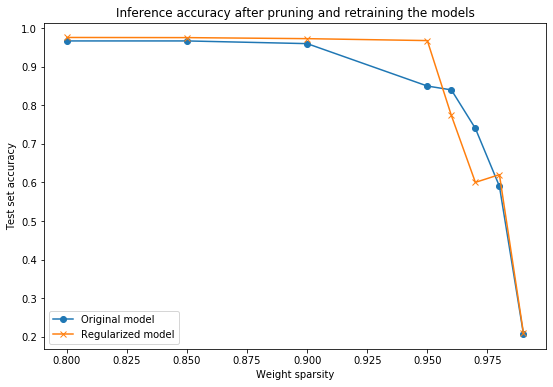

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(1,figsize=(9f,6))
plt.plot([0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99],[0.967,0.967,0.96,0.85,0.84,0.74,0.59,0.2068], label='Original model',marker='o')
plt.plot([0.8,0.85,0.9,0.95,0.96,0.97,0.98,0.99],[0.976,0.9756,0.9729,0.9679,0.7736,0.6001,0.6202,0.2092], label='Regularized model',marker='x')

# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.7296,0.7184,0.6972,0.6369,0.4878,0.4205], label='Original model',marker='o')
# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.734,0.7269,0.6999,0.64,0.5001,0.4502], label='Regularized model',marker='x')
plt.xlabel('Weight sparsity')
plt.ylabel('Test set accuracy')
plt.legend()
plt.title('Inference accuracy after pruning and retraining the models')
fig.savefig('reguVorig.pdf')

### Define additional weights, modified model and the new cost function 

In [ ]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 784])
XX = tf.reshape(X,[-1,784])
Y = tf.placeholder(tf.float32, [None, 10])
learning_rate = tf.placeholder(tf.float32, shape=[])
beta = tf.placeholder(tf.float32, shape=[])

# W1 = tf.Variable(tf.random_uniform(shape=[784, 200], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B1 = tf.Variable(tf.ones([200])*0.1)

# W2 = tf.Variable(tf.random_uniform(shape=[200, 100], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B2 = tf.Variable(tf.ones([100])*0.1)

# W3 = tf.Variable(tf.random_uniform(shape=[100, 60], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B3 = tf.Variable(tf.ones([60])*0.1)

# W4 = tf.Variable(tf.random_uniform(shape=[60, 30], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B4 = tf.Variable(tf.ones([30])*0.1)

# W5 = tf.Variable(tf.random_uniform(shape=[30, 10], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B5 = tf.Variable(tf.ones([10])*0.1)

with tf.variable_scope('Layer_1') as scope:
    W1 = tf.Variable(tf.random_uniform(shape=[784, 200], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
    B1 = tf.Variable(tf.ones([200])*0.1)
    Y1_hat = tf.nn.relu(tf.matmul(XX, pruning.apply_mask(W1,scope)) + B1,name=scope.name)
with tf.variable_scope('Layer_2') as scope:
    W2 = tf.Variable(tf.random_uniform(shape=[200, 100], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W2"))
    B2 = tf.Variable(tf.ones([100])*0.1)
    Y2_hat = tf.nn.relu(tf.matmul(Y1_hat, pruning.apply_mask(W2,scope)) + B2,name=scope.name)
with tf.variable_scope('Layer_3') as scope:
    W3 = tf.Variable(tf.random_uniform(shape=[100, 60], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W3"))
    B3 = tf.Variable(tf.ones([60])*0.1)
    Y3_hat = tf.nn.relu(tf.matmul(Y2_hat, pruning.apply_mask(W3,scope)) + B3,name=scope.name)
with tf.variable_scope('Layer_4') as scope:
    W4 = tf.Variable(tf.random_uniform(shape=[60, 30], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W4"))
    B4 = tf.Variable(tf.ones([30])*0.1)
    Y4_hat = tf.nn.relu(tf.matmul(Y3_hat, pruning.apply_mask(W4,scope)) + B4,name=scope.name)
with tf.variable_scope('Layer_5') as scope:
    W5 = tf.Variable(tf.random_uniform(shape=[30, 10], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W5"))
    B5 = tf.Variable(tf.ones([10])*0.1)
    Y_hat = tf.matmul(Y4_hat, pruning.apply_mask(W5,scope)) + B5

# New variables
# W1_ = tf.Variable(tf.random_uniform(shape=[784, 200], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B1_ = tf.Variable(tf.ones([200])*0.1)

# W2_ = tf.Variable(tf.random_uniform(shape=[200, 100], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B2_ = tf.Variable(tf.ones([100])*0.1)

# W3_ = tf.Variable(tf.random_uniform(shape=[100, 60], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B3_ = tf.Variable(tf.ones([60])*0.1)

# W4_ = tf.Variable(tf.random_uniform(shape=[60, 30], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B4_ = tf.Variable(tf.ones([30])*0.1)

# W5_ = tf.Variable(tf.random_uniform(shape=[30, 10], minval=-0.2, maxval=0.2, dtype=tf.float32))
# B5_ = tf.Variable(tf.ones([10])*0.1)

with tf.variable_scope('Layer_1new') as scope:
    W1_ = tf.Variable(tf.random_uniform(shape=[784, 200], minval=-0.2, maxval=0.2, dtype=tf.float32))
    B1_ = tf.Variable(tf.ones([200])*0.1)
    Y1_ = tf.nn.relu(tf.matmul(XX, pruning.apply_mask(W1_,scope)) + B1,name=scope.name)
with tf.variable_scope('Layer_2new') as scope:
    W2_ = tf.Variable(tf.random_uniform(shape=[200, 100], minval=-0.2, maxval=0.2, dtype=tf.float32))
    B2_ = tf.Variable(tf.ones([100])*0.1)
    Y2_ = tf.nn.relu(tf.matmul(Y1_, pruning.apply_mask(W2_,scope)) + B2,name=scope.name)
with tf.variable_scope('Layer_3new') as scope:
    W3_ = tf.Variable(tf.random_uniform(shape=[100, 60], minval=-0.2, maxval=0.2, dtype=tf.float32))
    B3_ = tf.Variable(tf.ones([60])*0.1)
    Y3_ = tf.nn.relu(tf.matmul(Y2_, pruning.apply_mask(W3_,scope)) + B3,name=scope.name)
with tf.variable_scope('Layer_4new') as scope:
    W4_ = tf.Variable(tf.random_uniform(shape=[60, 30], minval=-0.2, maxval=0.2, dtype=tf.float32))
    B4_ = tf.Variable(tf.ones([30])*0.1)
    Y4_ = tf.nn.relu(tf.matmul(Y3_, pruning.apply_mask(W4_,scope)) + B4,name=scope.name)
with tf.variable_scope('Layer_5new') as scope:
    W5_ = tf.Variable(tf.random_uniform(shape=[30, 10], minval=-0.2, maxval=0.2, dtype=tf.float32))
    B5_ = tf.Variable(tf.ones([10])*0.1)
    Y_ = tf.matmul(Y4_, pruning.apply_mask(W5_,scope)) + B5
    
# ## Original model
# XX = tf.reshape(X,[-1,784])

# Y1_hat = tf.nn.relu(tf.matmul(XX, W1) + B1)
# Y2_hat = tf.nn.relu(tf.matmul(Y1_hat, W2) + B2)
# Y3_hat = tf.nn.relu(tf.matmul(Y2_hat, W3) + B3)
# Y4_hat = tf.nn.relu(tf.matmul(Y3_hat, W4) + B4)
# Y_hat = tf.matmul(Y4_hat, W5) + B5

# # New model
# Y1_ = tf.nn.relu(tf.matmul(XX, W1_) + B1_)
# Y2_ = tf.nn.relu(tf.matmul(Y1_, W2_) + B2_)
# Y3_ = tf.nn.relu(tf.matmul(Y2_, W3_) + B3_)
# Y4_ = tf.nn.relu(tf.matmul(Y3_, W4_) + B4_)
# Y_ = tf.matmul(Y4_, W5_) + B5_

# beta = 0.0001
loss_1 = tf.losses.mean_squared_error(Y1_hat, Y1_)
loss_2 = tf.losses.mean_squared_error(Y2_hat, Y2_)
loss_3 = tf.losses.mean_squared_error(Y3_hat, Y3_)
loss_4 = tf.losses.mean_squared_error(Y4_hat, Y4_)
loss_5 = tf.losses.mean_squared_error(Y, Y_)

#regularizer = tf.nn.l2_loss(W)  #which regularzation to use
regularizer1 = tf.norm(W1_,ord=1) + tf.norm(B1_,ord=1)
regularizer2 = tf.norm(W2_,ord=1) + tf.norm(B2_,ord=1)
regularizer3 = tf.norm(W3_,ord=1) + tf.norm(B3_,ord=1)
regularizer4 = tf.norm(W4_,ord=1) + tf.norm(B4_,ord=1)
regularizer5 = tf.norm(W5_,ord=1) + tf.norm(B5_,ord=1)

new_loss1 = tf.reduce_mean(loss_1 + beta * regularizer1) 
new_loss2 = tf.reduce_mean(loss_2 + beta * regularizer2) 
new_loss3 = tf.reduce_mean(loss_3 + beta * regularizer3) 
new_loss4 = tf.reduce_mean(loss_4 + beta * regularizer4) 
new_loss5 = tf.reduce_mean(loss_5 + beta * regularizer5) 

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step1 = optimizer.minimize(new_loss1,var_list=[W1_,B1_])
train_step2 = optimizer.minimize(new_loss2,var_list=[W2_,B2_])
train_step3 = optimizer.minimize(new_loss3,var_list=[W3_,B3_])
train_step4 = optimizer.minimize(new_loss4,var_list=[W4_,B4_])
train_step5 = optimizer.minimize(new_loss5,var_list=[W5_,B5_])
#########################
##Execute the new model##
#########################


### Execute the new 5 layer model

In [ ]:
# init
init = tf.global_variables_initializer()
saver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5})
newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
                           "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})
lr_min = 0.0001
lr_max = 0.005
decay_speed = 4000
n_epochs = 1000

with tf.Session() as sess:
    sess.run(init)
    
    ## A. Define training step and restore original trained weights
    saver.restore(sess, "./Thesis_savedModels/5L_MNIST_fullyTrained.ckpt")
    for epoch in range(n_epochs):
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step1, {X:batch_xs, Y:batch_ys, learning_rate:temp, beta:0.00001})
        if epoch%200 == 0:
            print(sess.run([new_loss1,loss_1],{X:batch_xs, Y:batch_ys, beta:0.00001}))  
    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/5L_newL1trained.ckpt")
    print("New model with trained L1 saved in path: %s" % save_path)
    
    
    ## B. Define training step and restore original trained weights
#     saver.restore(sess, "./Thesis_savedModels/5L_newL1trained.ckpt")
    for epoch in range(n_epochs):
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step2, {X:batch_xs, Y:batch_ys, learning_rate:temp, beta:0.0001})
        if epoch%200 == 0:
            print(sess.run([new_loss2,loss_2],{X:batch_xs, Y:batch_ys, beta:0.0001}))
    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/5L_newL2trained.ckpt")
    print("New model with trained L2 saved in path: %s" % save_path)
    
    
    ## C. Define training step and restore original trained weights
#     saver.restore(sess, "./Thesis_savedModels/5L_newL2trained.ckpt")
    for epoch in range(n_epochs):
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step3, {X:batch_xs, Y:batch_ys, learning_rate:temp, beta:0.001})
        if epoch%200 == 0:
            print(sess.run([new_loss3,loss_3],{X:batch_xs, Y:batch_ys, beta:0.001}))
    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/5L_newL3trained.ckpt")
    print("New model with trained L3 saved in path: %s" % save_path)
    
    ## D. Define training step and restore original trained weights
#     saver.restore(sess, "./Thesis_savedModels/5L_newL3trained.ckpt")
    for epoch in range(n_epochs):
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step4, {X:batch_xs, Y:batch_ys, learning_rate:temp, beta:0.005})
        if epoch%200 == 0:
            print(sess.run([new_loss4,loss_4],{X:batch_xs, Y:batch_ys, beta:0.005}))
    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/5L_newL4trained.ckpt")
    print("New model with trained L4 saved in path: %s" % save_path) 
            
    ## E. Define training step and restore original trained weights
#     saver.restore(sess, "./Thesis_savedModels/5L_newL4trained.ckpt")
    for epoch in range(n_epochs):
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(train_step5, {X:batch_xs, Y:batch_ys, learning_rate:temp, beta:0.01})
        if epoch%200 == 0:
            print(sess.run([new_loss5,loss_5],{X:batch_xs, Y:batch_ys, beta:0.01}))
    #Save trained model
    save_path = newSaver.save(sess, "./Thesis_savedModels/5L_newL5trained.ckpt")
    print("New model with trained L5 saved in path: %s" % save_path) 
    
    ######### Evaluate Performance ###########
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    correct_prediction_orig = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_orig = tf.reduce_mean(tf.cast(correct_prediction_orig, tf.float32))

    print('New model accuracy:',sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    print('Original model accuracy:',sess.run(accuracy_orig, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    

INFO:tensorflow:Restoring parameters from ./Thesis_savedModels/5L_MNIST_fullyTrained.ckpt
[2.1509573, 1.9969327]
[0.12787712, 0.064312398]
[0.089677833, 0.031911656]
[0.081410542, 0.025200907]
[0.078091457, 0.022056852]
New model with trained L1 saved in path: ./Thesis_savedModels/5L_newL1trained.ckpt
[21.406248, 21.206003]
[0.80809152, 0.63421476]
[0.4717769, 0.30164447]
[0.40954936, 0.23817031]
[0.39378896, 0.2229635]
New model with trained L2 saved in path: ./Thesis_savedModels/5L_newL2trained.ckpt
[261.90088, 261.30576]
[4.4251504, 3.805743]
[3.4969647, 2.9185221]
[3.1326478, 2.5749805]
[2.8027325, 2.250603]
New model with trained L3 saved in path: ./Thesis_savedModels/5L_newL3trained.ckpt
[451.48456, 450.62021]
[14.172069, 12.931821]
[13.47792, 12.245325]
[13.224568, 12.005357]
[13.089064, 11.882117]
New model with trained L4 saved in path: ./Thesis_savedModels/5L_newL4trained.ckpt
[189.01051, 185.98746]
[1.1280832, 0.32339999]
[0.49039432, 0.11574476]
[0.23552743, 0.056234799]
[0

### Pruning the new 5 layer model

In [ ]:
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 250
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 250
pruning_hparams.target_sparsity = .96

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

beta = 0.01
# newLoss_retraining = tf.reduce_mean(-tf.reduce_sum(Y * tf.math.log(Y_), reduction_indices=[1]))
newLoss_retraining = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_)
newLoss_retraining = tf.reduce_mean(newLoss_retraining) * 100
train_step = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(newLoss_retraining, global_step=global_step)

init = tf.global_variables_initializer()

# newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
                           "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})
allSaver = tf.train.Saver() # To store pruning mask as well

n_epochs = 2000

with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    newSaver.restore(sess, "./Thesis_savedModels/5L_newL5trained.ckpt")
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy of new model: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    sess.run(prune_op)
    print("Sparsity after pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after just pruning: ",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    print("Starting with retraining")
    

    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        sess.run(prune_op)
        sess.run(train_step, {X:batch_xs, Y:batch_ys})
        if epoch%200 == 0:
            print(sess.run([newLoss_retraining],{X:batch_xs, Y:batch_ys}))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = allSaver.save(sess, "./Thesis_savedModels/5L_MNIST_newWeights_pruned.ckpt")
    print("Model saved in path: %s \n" % save_path)
    print("Final Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
######### Results #############
# Sparsity:0.99    Accuracy(1epoch):~         Accuracy(1000epochs):0.2092      Accuracy(2000epochs):
# Sparsity:0.98    Accuracy(1epoch):          Accuracy(1000epochs):0.6202      Accuracy(2000epochs):
# Sparsity:0.97    Accuracy(1epoch):          Accuracy(1000epochs):0.6001      Accuracy(2000epochs):
# Sparsity:0.96    Accuracy(1epoch):          Accuracy(1000epochs):0.7736      Accuracy(2000epochs):0.7696
# Sparsity:0.95    Accuracy(1epoch):0.6032    Accuracy(1000epochs):0.9679      Accuracy(2000epochs):
# Sparsity:0.90    Accuracy(1epoch):          Accuracy(1000epochs):0.9729      Accuracy(2000epochs):
# Sparsity:0.85    Accuracy(1epoch):          Accuracy(1000epochs):0.9756      Accuracy(2000epochs):

# [0.976,0.9756,0.9729,0.9679,0.7736,0.6001,0.6202,0.2092]

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=250,weight_sparsity_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.96,sparsity_function_begin_step=0,sparsity_function_end_step=250,sparsity_function_exponent=3.0,use_tpu=False
Accuracy of new model:  0.954
Sparsity before pruning [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Sparsity after pruning [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Accuracy after just pruning:  0.954
Starting with retraining
[166.79701]
Weight sparsities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[101.034836]
Weight sparsities: [0.9523214, 0.95229995, 0.95233333, 0.9522222, 0.9533334, 0.9523214, 0.95229995, 0.95233333, 0.9522222, 0.9533334]
[57.68239]
Weight sparsities: [0.96, 0.96, 0.96, 0.96000004, 0.96000004, 0.96, 0.96, 0.96, 0.96000004, 0.96000004]
[48.57763]
Weight sparsities: [0.96, 0.96, 0.96, 0

### Quantize new model

In [ ]:
init = tf.global_variables_initializer()
# newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
                           "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})


with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    allSaver.restore(sess, "./Thesis_savedModels/5L_newL5trained.ckpt")

    # Print max and min weight values
    maxW = sess.run(tf.math.reduce_max(W1))
    minW = sess.run(tf.math.reduce_min(W1))
    meanW = sess.run(tf.math.reduce_mean(parameters))
    print("{min,max,mean}: {",minW,maxW,meanW,"}")
    
    # Evaluate performance
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test accuracy before quant:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))
    
#     check = sess.run(tf.equal(parameters[:img_size,:h1],W1))
#     print(check)
    
    multiplier = 2  #16 for 4 bits, 32 for 8 bits
    clip_min = -4
    clip_max = 4
    
    quant_op1 = W1_.assign(tf.math.round(tf.clip_by_value(W1_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op2 = W2_.assign(tf.math.round(tf.clip_by_value(W2_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op3 = W3_.assign(tf.math.round(tf.clip_by_value(W3_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op4 = W4_.assign(tf.math.round(tf.clip_by_value(W4_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op5 = W5_.assign(tf.math.round(tf.clip_by_value(W5_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op6 = B1_.assign(tf.math.round(tf.clip_by_value(B1_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op7 = B2_.assign(tf.math.round(tf.clip_by_value(B2_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op8 = B3_.assign(tf.math.round(tf.clip_by_value(B3_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op9 = B4_.assign(tf.math.round(tf.clip_by_value(B4_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op10 = B5_.assign(tf.math.round(tf.clip_by_value(B5_,clip_min,clip_max)*multiplier)/multiplier)
    
    sess.run(quant_op1)
    sess.run(quant_op2)
    sess.run(quant_op3)
    sess.run(quant_op4)
    sess.run(quant_op5)
    sess.run(quant_op6)
    sess.run(quant_op7)
    sess.run(quant_op8)
    sess.run(quant_op9)
    sess.run(quant_op10)
    
    # Evaluate performance
    correct_prediction = tf.equal(tf.argmax(Y_,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print('Test accuracy after quant:', sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))


---
# 4. Overfitting and Dropout
You will have noticed that cross-entropy curves for test and training data start disconnecting after a couple thousand iterations. The learning algorithm works on training data only and optimises the training cross-entropy accordingly. It never sees test data so it is not surprising that after a while its work no longer has an effect on the test cross-entropy which stops dropping and sometimes even bounces back up. 
<img src="figs/14-overfit.png" style="width: 500px;"/>
This disconnect is usually labeled **overfitting** and when you see it, you can try to apply a regularisation technique called **dropout**. In dropout, at each training iteration, you drop random neurons from the network. You choose a probability `pkeep` for a neuron to be kept, usually between 50% and 75%, and then at each iteration of the training loop, you randomly remove neurons with all their weights and biases. Different neurons will be dropped at each iteration. When testing the performance of your network of course you put all the neurons back (`pkeep = 1`).
<img src="figs/15-dropout.png" style="width: 500px;"/>
TensorFlow offers a dropout function to be used on the outputs of a layer of neurons. It randomly zeroes-out some of the outputs and boosts the remaining ones by `1 / pkeep`. You can add dropout after each intermediate layer in the network now. 

In the following code, use the dropout between each layer during the training, and set the probability `pkeep` once to $50%$ and another time to $75%$ and compare their results.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# neural network with 5 layers
#
# · · · · · · · · · ·          (input data, flattened pixels)       X [batch, 784]   
# \x/x\x/x\x/x\x/x\x/       -- fully connected layer (sigmoid)      W1 [784, 200]      B1[200]
#  · · · · · · · · ·                                                Y1_hat [batch, 200]
#   \x/x\x/x\x/x\x/         -- fully connected layer (sigmoid)      W2 [200, 100]      B2[100]
#    · · · · · · ·                                                  Y2_hat [batch, 100]
#     \x/x\x/x\x/           -- fully connected layer (sigmoid)      W3 [100, 60]       B3[60]
#      · · · · ·                                                    Y3_hat [batch, 60]
#       \x/x\x/             -- fully connected layer (sigmoid)      W4 [60, 30]        B4[30]
#        · · ·                                                      Y4_hat [batch, 30]
#         \x/               -- fully connected layer (softmax)      W5 [30, 10]        B5[10]
#          ·                                                        Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])

# variable learning rate
learning_rate = tf.placeholder(tf.float32, shape=[])

# probability of keeping a node during dropout = 1.0 at test time (no dropout) and 0.75 at training time
pkeep = 0.75

# five layers and their number of neurons, i.e., 200, 100, 60, 30, and 10
# when using RELUs, make sure biases are initialised with small positive values, for example 0.1

W1 = tf.Variable(tf.random_uniform(shape=[784, 200], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B1 = tf.Variable(tf.ones([200])*0.1)

W2 = tf.Variable(tf.random_uniform(shape=[200, 100], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W2"))
B2 = tf.Variable(tf.ones([100])*0.1)

W3 = tf.Variable(tf.random_uniform(shape=[100, 60], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W3"))
B3 = tf.Variable(tf.ones([60])*0.1)

W4 = tf.Variable(tf.random_uniform(shape=[60, 30], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W4"))
B4 = tf.Variable(tf.ones([30])*0.1)

W5 = tf.Variable(tf.random_uniform(shape=[30, 10], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W5"))
B5 = tf.Variable(tf.ones([10])*0.1)

########################################
# build the model
########################################
XX = tf.reshape(X,[-1,784])

Y1_hat = tf.nn.relu(tf.matmul(XX, W1) + B1)
Y1_hat_dropout = tf.nn.dropout(Y1_hat,pkeep)

Y2_hat = tf.nn.relu(tf.matmul(Y1_hat, W2) + B2)
Y2_hat_dropout = tf.nn.dropout(Y2_hat,pkeep)

Y3_hat = tf.nn.relu(tf.matmul(Y2_hat, W3) + B3)
Y3_hat_dropout = tf.nn.dropout(Y3_hat,pkeep)

Y4_hat = tf.nn.relu(tf.matmul(Y3_hat, W4) + B4)
Y4_hat_dropout = tf.nn.dropout(Y4_hat,pkeep)

Y_hat = tf.matmul(Y4_hat_dropout, W5) + B5
########################################
# defining the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_hat)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optimizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

lr_min = 0.0001
lr_max = 0.005
decay_speed = 2000
n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
#         batch_xs, batch_ys = mnist.train.next_batch(200)
        batch_xs = mnist.train.images
        batch_ys = mnist.train.labels
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        sess.run(train_step, feed_dict={X:batch_xs, Y:batch_ys, learning_rate:temp})
        if epoch%200 == 0:
            print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

---
# 6. Convolutional Network
<img src="figs/16-comic6.png" style="width: 500px;"/>
In the previous sections, all pixels of images flattened into a single vector, which was a really bad idea. Handwritten digits are made of shapes and we discarded the shape information when we flattened the pixels. However, we can use **convolutional neural networks (CNN)** to take advantage of shape information. CNNs apply *a series of filters* to the raw pixel data of an image to extract and learn higher-level features, which the model can then use for classification. CNNs contains three components:
  - **Convolutional layers**: apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. Convolutional layers then typically apply a ReLU activation function to the output to introduce nonlinearities into the model.
  - **Pooling layers**: downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. A commonly used pooling algorithm is max pooling, which extracts subregions of the feature map (e.g., 2x2-pixel tiles), keeps their maximum value, and discards all other values.
  - **Dense (fully connected) layers**: perform classification on the features extracted by the convolutional layers and downsampled by the pooling layers. In a dense layer, every node in the layer is connected to every node in the preceding layer.
  
Typically, a CNN is composed of a *stack of **convolutional modules*** that perform feature extraction. Each *module* consists of a *convolutional layer* followed by a *pooling layer*. The last convolutional module is followed by one or more dense layers that perform classification. The final dense layer in a CNN contains a single neuron for each target class in the model, with a softmax activation function to generate a value between 0-1 for each neuron. We can interpret the softmax values for a given image as relative measurements of how likely it is that the image falls into each target class.

Now, let us build a convolutional network for handwritten digit recognition. In this assignment, we will use the architecture shown in the following figure that has three convolutional layers, one fully-connected layer, and one softmax layer. Notice that the second and third convolutional layers have a stride of two that explains why they bring the number of output values down from 28x28 to 14x14 and then 7x7. A convolutional layer requires a weights tensor like `[4, 4, 3, 2]`, in which the first two numbers define the size of a filter (map), the third number shows the *depth* of the filter that is the number of *input channel*, and the last number shows the number of *output channel*. The output channel defines the number of times that we repeat the same thing with a different set of weights in one layer. In our implementation, we assume the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected layer is 200.
<img src="figs/17-arch1.png" style="width: 600px;"/>

Convolutional layers can be implemented in TensorFlow using the `tf.nn.conv2d` function, which performs the scanning of the input image in both directions using the supplied weights. This is only the weighted sum part of the neuron. You still need to add a bias and feed the result through an activation function. The padding strategy that works here is to copy pixels from the sides of the image. All digits are on a uniform background so this just extends the background and should not add any unwanted shapes.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·      (input data, 1-deep)               X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @   -- conv. layer 5x5x1=>4 stride 1      W1 [5, 5, 1, 4]        B1 [4]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 4]
#   @ @ @ @ @ @ @ @     -- conv. layer 5x5x4=>8 stride 2      W2 [5, 5, 4, 8]        B2 [8]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 8]
#     @ @ @ @ @ @       -- conv. layer 4x4x8=>12 stride 2     W3 [4, 4, 8, 12]       B3 [12]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 12] => reshaped to YY [batch, 7*7*12]
#      \x/x\x\x/        -- fully connected layer (relu)       W4 [7*7*12, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/         -- fully connected layer (softmax)    W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])
learning_rate = tf.placeholder(tf.float32, shape=[])

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected
# layer is 200

W1 = tf.Variable(tf.random_uniform(shape=[5, 5, 1, 4], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B1 = tf.Variable(tf.ones([4])*0.1)

W2 = tf.Variable(tf.random_uniform(shape=[5, 5, 4, 8], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B2 = tf.Variable(tf.ones([8])*0.1)

W3 = tf.Variable(tf.random_uniform(shape=[4, 4, 8, 12], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B3 = tf.Variable(tf.ones([12])*0.1)

W4 = tf.Variable(tf.random_uniform(shape=[7*7*12, 200], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B4 = tf.Variable(tf.ones([200])*0.1)

W5 = tf.Variable(tf.random_uniform(shape=[200, 10], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B5 = tf.Variable(tf.ones([10])*0.1)

########################################
# build the model
########################################
XX = tf.reshape(X,[-1,28,28,1])

stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.nn.conv2d(XX,W1,[1,stride,stride,1],padding='SAME') + B1) # use tf.nn.conv2d

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.nn.conv2d(Y1_hat,W2,[1,stride,stride,1],padding='SAME') + B2)

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.nn.conv2d(Y2_hat,W3,[1,stride,stride,1],padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat,[-1,7*7*12])
Y4_hat = tf.nn.relu(tf.matmul(YY_hat, W4) + B4)
Y_hat = tf.matmul(Y4_hat, W5) + B5

########################################
# define the cost function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_hat)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# define the optmizer
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 1000
lr_min = 0.0001
lr_max = 0.005
decay_speed = 2000
n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(200)
#         batch_xs = mnist.train.images
#         batch_ys = mnist.train.labels
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        sess.run(train_step, feed_dict={X:batch_xs, Y:batch_ys, learning_rate:temp})
        if epoch%200 == 0:
            print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

[228.25482]
[7.3045201]
[2.4943535]
[4.7702451]
[1.8778272]
[1.565606]
[1.6357379]
[2.6961508]
[4.3175831]
[0.63940525]
[6.681179]
[2.2090421]
[4.3373818]
[2.5502486]
[2.1729236]
[2.9253578]
[5.8789129]
[9.0121899]
[9.4664974]


KeyboardInterrupt: 

# 7. Improve The Performance
A good approach to sizing your neural networks is to implement a network that is a little too constrained, then give it a bit more degrees of freedom and add dropout to make sure it is not overfitting. This ends up with a fairly optimal network for your problem. In the above model, we set the output channel to 4 in the first convolutional layer, which means that we repeat the same filter shape (but with different weights) four times. If we assume that those filters evolve during training into shape recognisers, you can intuitively see that this might not be enough for our problem. Handwritten digits are made from more than 4 elemental shapes. So let us bump up the filter sizes a little, and also increase the number of filters in our convolutional layers from 4, 8, 12 to 6, 12, 24 and then add dropout on the fully-connected layer. The following figure shows the new architecture you should build. Please complete the following code based on the given architecture and dropout technique.
<img src="figs/18-arch2.png" style="width: 600px;"/>

In [ ]:
# TODO: Replace <FILL IN> with appropriate code

# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [6, 6, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]

# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])
learning_rate = tf.placeholder(tf.float32, shape=[])
pkeep = 0.75

# three convolutional layers with their channel counts, and a fully connected layer 
# (the last layer has 10 softmax neurons)
# the output depth of first three convolutional layers, are 4, 8, 12, and the size of fully connected
# layer is 200

W1 = tf.Variable(tf.random_uniform(shape=[6, 6, 1, 6], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W1"))
B1 = tf.Variable(tf.ones([6])*0.1)

W2 = tf.Variable(tf.random_uniform(shape=[5, 5, 6, 12], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W2"))
B2 = tf.Variable(tf.ones([12])*0.1)

W3 = tf.Variable(tf.random_uniform(shape=[4, 4, 12, 24], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W3"))
B3 = tf.Variable(tf.ones([24])*0.1)

W4 = tf.Variable(tf.random_uniform(shape=[7*7*24, 200], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W4"))
B4 = tf.Variable(tf.ones([200])*0.1)

W5 = tf.Variable(tf.random_uniform(shape=[200, 10], minval=-0.2, maxval=0.2, dtype=tf.float32,name="W5"))
B5 = tf.Variable(tf.ones([10])*0.1)

########################################
# build the model
########################################
XX = tf.reshape(X,[-1,28,28,1])

stride = 1  # output is 28x28
Y1_hat = tf.nn.relu(tf.nn.conv2d(XX,W1,[1,stride,stride,1],padding='SAME') + B1)

stride = 2  # output is 14x14
Y2_hat = tf.nn.relu(tf.nn.conv2d(Y1_hat,W2,[1,stride,stride,1],padding='SAME') + B2)

stride = 2  # output is 7x7
Y3_hat = tf.nn.relu(tf.nn.conv2d(Y2_hat,W3,[1,stride,stride,1],padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY_hat = tf.reshape(Y3_hat,[-1,7*7*24])
Y4_hat = tf.nn.relu(tf.matmul(YY_hat, W4) + B4)
YY4_hat = tf.nn.dropout(Y4_hat, pkeep)
Y_hat = tf.matmul(YY4_hat, W5) + B5

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_hat)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# traini the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 1000
lr_min = 0.0001
lr_max = 0.005
decay_speed = 2000
n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        batch_xs, batch_ys = mnist.train.next_batch(200)
#         batch_xs = mnist.train.images
#         batch_ys = mnist.train.labels
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        sess.run(train_step, feed_dict={X:batch_xs, Y:batch_ys, learning_rate:temp})
        if epoch%200 == 0:
            print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

[362.14172]
[8.9912014]
[9.2813148]
[6.156055]
[0.91782707]
[1.1493007]
[5.9999905]
[7.033843]
[4.923717]
[1.9812564]
[7.8677802]
[4.2305231]
[5.9245968]
[11.429906]
[11.590984]
[11.997126]
[8.8523293]
[11.345205]
[21.291979]
[36.53027]
[22.493607]
[24.179443]
[14.206854]
[28.075031]
[87.24086]
0.8258


---
# 8. Tensorflow Layers Module
The TensorFlow **layers** `tf.layers` module provides a high-level API that makes it easy to construct a neural network. It provides methods that facilitate: (i) the creation of dense (fully connected) layers and convolutional layers, (ii) adding activation functions, and (iii) applying dropout regularization. In this section use the module `tf.layers` to build the network you made in section 7.

In [ ]:
# TODO: Replace <FILL IN> with appropriate code
# · · · · · · · · · ·    (input data, 1-deep)                 X [batch, 28, 28, 1]
# @ @ @ @ @ @ @ @ @ @ -- conv. layer 6x6x1=>6 stride 1        W1 [6, 6, 1, 6]        B1 [6]
# ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                         Y1_hat [batch, 28, 28, 6]
#   @ @ @ @ @ @ @ @   -- conv. layer 5x5x6=>12 stride 2       W2 [5, 5, 6, 12]        B2 [12]
#   ∶∶∶∶∶∶∶∶∶∶∶∶∶∶∶                                           Y2_hat [batch, 14, 14, 12]
#     @ @ @ @ @ @     -- conv. layer 4x4x12=>24 stride 2      W3 [4, 4, 12, 24]       B3 [24]
#     ∶∶∶∶∶∶∶∶∶∶∶                                             Y3_hat [batch, 7, 7, 24] => reshaped to YY [batch, 7*7*24]
#      \x/x\x\x/ ✞    -- fully connected layer (relu+dropout) W4 [7*7*24, 200]       B4 [200]
#       · · · ·                                               Y4_hat [batch, 200]
#       \x/x\x/       -- fully connected layer (softmax)      W5 [200, 10]           B5 [10]
#        · · ·                                                Y_hat [batch, 10]
# to reset the Tensorflow default graph
reset_graph()

########################################
# define variables and placeholders
########################################
X = tf.placeholder(tf.float32, [None, 784])
Y = tf.placeholder(tf.float32, [None, 10])
learning_rate = tf.placeholder(tf.float32, shape=[])
pkeep = 0.75

########################################
# build the model
########################################
XX = tf.reshape(X,[-1,28,28,1])
stride = 1
conv1 = tf.layers.conv2d(inputs=XX, filters=6, kernel_size=[6, 6], strides=(stride,stride), padding="same", activation=tf.nn.relu)
stride = 2 
conv2 = tf.layers.conv2d(inputs=conv1, filters=12, kernel_size=[5, 5], strides=(stride,stride), padding="same", activation=tf.nn.relu)
stride = 2 
conv3 = tf.layers.conv2d(inputs=conv2, filters=24, kernel_size=[4, 4], strides=(stride,stride), padding="same", activation=tf.nn.relu)

YY_hat = tf.reshape(conv3,[-1,7*7*24])
hidden = tf.layers.dense(inputs=YY_hat, units=200, activation=tf.nn.relu)
dropout = tf.layers.dropout(inputs=hidden, rate=pkeep)

Y_hat = tf.layers.dense(inputs=dropout, units=10)

########################################
# define the Loss function
########################################
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=Y_hat)
cross_entropy = tf.reduce_mean(cross_entropy) * 100

########################################
# traini the model
########################################
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(cross_entropy)

########################################
# execute the model
########################################
init = tf.global_variables_initializer()

n_epochs = 1000
lr_min = 0.0001
lr_max = 0.005
decay_speed = 2000
n_epochs = 5000
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):        
        batch_xs, batch_ys = mnist.train.next_batch(200)
#         batch_xs = mnist.train.images
#         batch_ys = mnist.train.labels
        temp = lr_min+(lr_max-lr_min)*np.exp(epoch/decay_speed)
        sess.run(train_step, feed_dict={X:batch_xs, Y:batch_ys, learning_rate:temp})
        if epoch%200 == 0:
            print(sess.run([cross_entropy],{X:batch_xs, Y:batch_ys}))
    
    correct_prediction = tf.equal(tf.argmax(Y_hat,1), tf.argmax(Y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels}))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

[216.99124]
[4.8278899]
[6.6093216]
[6.9947286]
[1.3914328]
[1.2818573]
[1.1096337]
[2.7787294]
[1.9156803]
[3.5492527]
[2.3706384]
[2.0463314]
[2.103735]
[6.2535553]
[4.2616982]
[4.4340916]
[8.7176628]
[5.9110904]
[11.90553]
[9.4472494]
[8.1140652]
[20.559086]
[28.710091]
[38.730492]
[14.762802]
0.9176


---
# 10. Implement AlexNet
 **AlexNet** [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).
The AlexNet CNN architecture won the [ImageNet ILSVRC challenge](http://www.image-net.org/challenges/LSVRC/2012/) in 2012 by a large margin. It was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton. It is quite similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of each other, instead of stacking a pooling layer on top of each convolutional layer. The following table presents this architecture.
<img src="drive/My Drive/Colab Notebooks/figs/20-alexnet.png" style="width: 600px;"/>
To train the model, we need a big dataset, however, we can use the pretrained weights for the model available at [bvlc_alexnet.npy](https://www.cs.toronto.edu/~guerzhoy/tf_alexnet/bvlc_alexnet.npy). 
This file is a NumPy array file created by the python. After you read this file, you will receive a python dictionary with a <key, value> pair for each layer. Each key is one of the layers names, e.g., `conv1`, and each value is a list of two values: (1) weights, and (2) biases of that layer. Part of the function to load the weights and biases to your model is given, and you need to complete it.
Here is what you see if you read and print the shape of each layer from the file:
```
weight_dic = np.load("bvlc_alexnet.npy", encoding="bytes").item()
for layer in weights_dic:
    print("-" * 20)
    print(layer)
    for wb in weights_dic[layer]:
        print(wb.shape)

#--------------------
# fc8
# (4096, 1000) # weights
# (1000,) # bias
#--------------------
# fc7
# (4096, 4096) # weights
# (4096,) # bias
#--------------------
# fc6
# (9216, 4096) # weights
# (4096,) # bias
#--------------------
# conv5
# (3, 3, 192, 256) # weights
# (256,) # bias
#--------------------
# conv4
# (3, 3, 192, 384) # weights
# (384,) # bias
#--------------------
# conv3
# (3, 3, 256, 384) # weights
# (384,) # bias
#--------------------
# conv2
# (5, 5, 48, 256) # weights
# (256,) # bias
#--------------------
# conv1
# (11, 11, 3, 96) # weights
# (96,) # bias
```


### Load CIFAR-10 dataset

In [ ]:
# ! tar -xvf drive/My\ Drive/Colab\ Notebooks/cifar-10-python.tar
# ! mkdir drive/My\ Drive/Colab\ Notebooks/cifar-10-batches-py
# ! mv  -v cifar-10-batches-py/* drive/My\ Drive/Colab\ Notebooks/cifar-10-batches-py/

In [3]:
# Decide image size. (32 or 70)
img_size = 70

# Unpickle particular batch file into a dictionary
def __extract_file__(fname):
    with open(fname, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d

def __unflatten_image__(img_flat):
    img_R = img_flat[0:1024].reshape((32, 32))
    img_G = img_flat[1024:2048].reshape((32, 32))
    img_B = img_flat[2048:3072].reshape((32, 32))
    img = np.dstack((img_R, img_G, img_B))
    ##********##
    img = scipy.misc.imresize(img,size=(img_size,img_size),interp='bicubic')
    ##********##
    return img

# Extract only data and labels and then reshape for use  
def __extract_reshape_file__(fname):
    res = []
    d = __extract_file__(fname)
    images = d[b"data"]
    labels = d[b"labels"]
    for image, label in zip(images, labels):
        res.append((__unflatten_image__(image), label))
    return res
  
# Load data from all batches into a single variable 
def get_images_from(dir):
    files = [f for f in os.listdir(dir) if f.startswith("data_batch")]
    res = []
    for f in files:
        res = res + __extract_reshape_file__(os.path.join(dir, f))
    return res
    

class Cifar(object):

    def __init__(self, dir="data/cifar-10-batches-py/", batch_size=1):
        self.__res__ = get_images_from(dir)
        self.batch_size = batch_size
        self.batches = []
        self.__batch_num__ = 0
        # Divide the data into batches
        for i in range(math.ceil(len(self.__res__)/batch_size)):
            self.batches.append(self.__res__[i*batch_size:(i+1)*batch_size])
        self.test_set = __extract_reshape_file__(os.path.join(dir, "test_batch"))
        
    def batch(self, num):
        return self.batches[num]

    def next_batch(self):
        if self.__batch_num__ <= len(self.batches):
            res = self.batches[self.__batch_num__]
            self.__batch_num__ = self.__batch_num__ + 1
        else:
            res = []

        return res

    def reset_batch(self):
        self.__batch_num__ = 0

# Processing the batches to form input and output matrix        
def one_hot(num, dim=1000):
    vec = np.zeros(dim)
    vec[num] = 1
    return vec


def transform_to_input_output(input_output, dim=1000):
    input_vals = []
    output_vals = []
    for input_val, output_val in input_output:
        input_vals.append(input_val)
        output_vals.append(output_val)

    return np.array(input_vals), np.array([one_hot(out, dim=dim)
         for out in output_vals], dtype="uint8")

### Define original model

Removed LRN from model as double derivative of LRN not available in tensorflow.

In [4]:
""" build the AlexNet model
* Use Alexnet(), not Alexnet_small
* Function returns output of all important layers to help construct two networks 
with the same architecture later
* Removed LRN in final implementation as its double derivative is not natively 
supported by tensorflow. 
"""
from tensorflow import layers

# Used for convolving split layers with split kernel, with 2 gpu in parallel
def conv2d_split(X, filters, kernel_size, strides, name, activation):
    input_channels = int(X.get_shape()[-1])
    with tf.variable_scope(name):
        # Fetch kernel variable in name scope with given shape
        weights = tf.get_variable('kernel', initializer = random_values([kernel_size, kernel_size, int(input_channels/2), filters]))
        # Fetch bias variable in name scope with given shape
        biases = tf.get_variable('bias', initializer =tf.ones(shape=[filters], dtype=tf.float32))
    
    conv = lambda x, w: tf.nn.conv2d(x, w, strides = [1, strides, strides, 1], padding="SAME")
    
    input_groups = tf.split(axis = 3, num_or_size_splits=2, value=X)
    weight_groups = tf.split(axis = 3, num_or_size_splits=2, value=pruning.apply_mask(weights,name))
    output_groups = [conv(x, w) for x,w in zip(input_groups, weight_groups)]

    output = tf.concat(axis = 3, values = output_groups) + biases
    
    return activation(output)
    
random_mean = 0
random_stddev = 0.01
def random_values(shape):
    return tf.random_normal(shape=shape, mean=random_mean, stddev=random_stddev, dtype=tf.float32)

def AlexNet(X,pkeep = 0.5):
    print(np.shape(X))
    with tf.variable_scope('conv1'):
        w = tf.get_variable('kernel', initializer = random_values([11,11,3,96]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [96], dtype=tf.float32))
    # Choose stride from 1 or 4 depending on CIFAR or Imagenet    
    c1 = tf.nn.conv2d(X, pruning.apply_mask(w,'conv1'), strides = [1, 4, 4, 1], padding="SAME")
    c1 = c1 + b
    c1 = tf.nn.relu(c1)
    print(np.shape(c1))
#     c1 = layers.conv2d(X, filters=96, kernel_size=11, strides=4, padding="SAME", activation='relu', name='conv1')
    # lrn1 = tf.nn.lrn(c1, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m1 = layers.max_pooling2d(c1, pool_size=3, strides=2, padding="VALID")
        
    c2 = conv2d_split(m1, filters=256, kernel_size=5, strides=1, name="conv2", activation=tf.nn.relu)
    print(np.shape(c2))
    # lrn2 = tf.nn.lrn(c2, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m2 = layers.max_pooling2d(c2, pool_size=3, strides=2, padding="VALID")
    
    with tf.variable_scope('conv3'):
        w =  tf.get_variable('kernel', initializer = random_values([3,3,256,384]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [384]), dtype=tf.float32)
    c3 = tf.nn.conv2d(m2, pruning.apply_mask(w,'conv3'), strides = [1, 1, 1, 1], padding="SAME")
    c3 = c3 + b
    c3 = tf.nn.relu(c3)
#     c3 = layers.conv2d(m2, filters=384, kernel_size=3, strides=1, padding="SAME", activation='relu', name='conv3')
    print(np.shape(c3))
    c4 = conv2d_split(c3, filters=384, kernel_size=3, strides=1, name="conv4", activation=tf.nn.relu)
    print(np.shape(c4))
    
    c5 = conv2d_split(c4, filters=256, kernel_size=3, strides=1, activation=tf.nn.relu, name='conv5')
    print(np.shape(c5))
    m5 = layers.max_pooling2d(c5, pool_size=3, strides=2, padding="VALID")
    m5 = layers.flatten(m5)
    
    with tf.variable_scope('fc6'):
        w =  tf.get_variable('kernel', initializer = random_values([256,256]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [256]), dtype=tf.float32)
    f6 = tf.nn.relu(tf.matmul(m5, pruning.apply_mask(w,'fc6')) + b)
    print(np.shape(f6))
#     f6 = layers.dense(m5, 4096, activation='relu', name="fc6")

    with tf.variable_scope('fc7'):
        w =  tf.get_variable('kernel', initializer = random_values([256,128]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [128]), dtype=tf.float32)
    f7 = tf.nn.relu(tf.matmul(f6, pruning.apply_mask(w,'fc7')) + b)
    print(np.shape(f7))
#     f7 = layers.dense(f6, 4096, activation='relu', name="fc7")
    f7 = tf.nn.dropout(f7, keep_prob=pkeep, name='f7_dropout')
    # Set the number of output classes
    with tf.variable_scope('fc8'):
        w = tf.get_variable('kernel', initializer = random_values([128,10]))
        b = tf.get_variable('bias',initializer =tf.ones(shape = [10]), dtype=tf.float32)
    f8 = (tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
    print(np.shape(f8))
#     f8 = tf.nn.softmax(tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
#     f8 = layers.dense(f7, 1000, activation='softmax', name="fc8")
    f8 = tf.nn.dropout(f8, keep_prob=pkeep, name='f8_dropout')
    
    return [c1,c2,c3,c4,c5,f6,f7,f8]


def AlexNet_small(X):
    with tf.variable_scope('conv1'):
        w = tf.get_variable('kernel', [3,3,3,64])
        b = tf.get_variable('bias',shape = [64])
    # Choose stride from 1 or 4 depending on CIFAR or Imagenet    
    c1 = tf.nn.conv2d(X, pruning.apply_mask(w,'conv1'), strides = [1, 1, 1, 1], padding="SAME")
    c1 = c1 + b
    c1 = tf.nn.relu(c1)
    print(np.shape(c1))
#     c1 = layers.conv2d(X, filters=96, kernel_size=11, strides=4, padding="SAME", activation='relu', name='conv1')
    lrn1 = tf.nn.lrn(c1, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m1 = layers.max_pooling2d(lrn1, pool_size=2, strides=1, padding="VALID")
        
    c2 = conv2d_split(m1, filters=192, kernel_size=3, strides=2, name="conv2", activation=tf.nn.relu)
    print(np.shape(c2))
    lrn2 = tf.nn.lrn(c2, depth_radius=2, alpha=1e-05, beta=0.75, bias=1.0)
    m2 = layers.max_pooling2d(lrn2, pool_size=2, strides=1, padding="VALID")
    
    with tf.variable_scope('conv3'):
        w = tf.get_variable('kernel', [3,3,192,384])
        b = tf.get_variable('bias',shape = [384])
    c3 = tf.nn.conv2d(m2, pruning.apply_mask(w,'conv3'), strides = [1, 2, 2, 1], padding="SAME")
    c3 = c3 + b
    c3 = tf.nn.relu(c3)
#     c3 = layers.conv2d(m2, filters=384, kernel_size=3, strides=1, padding="SAME", activation='relu', name='conv3')
    print(np.shape(c3))
    c4 = conv2d_split(c3, filters=256, kernel_size=3, strides=1, name="conv4", activation=tf.nn.relu)
    print(np.shape(c4))
    
    c5 = conv2d_split(c4, filters=256, kernel_size=3, strides=1, activation=tf.nn.relu, name='conv5')
    print(np.shape(c5))
    m5 = layers.max_pooling2d(c5, pool_size=3, strides=2, padding="VALID")
    m5 = layers.flatten(m5)
    print(np.shape(m5))
    # Choose dim from [2304,512] or [9216,4096] depending on CIFAR or Imagenet  
    with tf.variable_scope('fc6'):
        w = tf.get_variable('kernel',[2304,1024])
        b = tf.get_variable('bias',shape=[1024])
    f6 = tf.nn.relu(tf.matmul(m5, pruning.apply_mask(w,'fc6')) + b)
#     f6 = layers.dense(m5, 4096, activation='relu', name="fc6")

    # Choose dim from [512,512] or [4096,4096] depending on CIFAR or Imagenet 
    with tf.variable_scope('fc7'):
        w = tf.get_variable('kernel',[1024,256])
        b = tf.get_variable('bias',shape=[256])
    f7 = tf.nn.relu(tf.matmul(f6, pruning.apply_mask(w,'fc7')) + b)
#     f7 = layers.dense(f6, 4096, activation='relu', name="fc7")

    # Set the number of output classes
    with tf.variable_scope('fc8'):
        w = tf.get_variable('kernel',[256,10])
        b = tf.get_variable('bias',shape=[10])
    f8 = (tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
#     f8 = tf.nn.softmax(tf.matmul(f7, pruning.apply_mask(w,'fc8')) + b)
#     f8 = layers.dense(f7, 1000, activation='softmax', name="fc8")

    return f8

# load inital weights and biases to the model
def load_initial_weights(session):
    # load the weights into memory
    weights_dict = np.load('drive/My Drive/Colab Notebooks/AlexNet_trained/bvlc_alexnet.npy', encoding='bytes').item()
    # Create a dictionary with all global variables available
    var_dict = dict((v.name, v) for v in tf.global_variables())
    #print(v for v in var_dict.keys())
    # loop over all layer names stored in the weights dict
    for layer in weights_dict:
        with tf.variable_scope(layer, reuse=True):
            # loop over list of weights/biases and assign them to their corresponding tf variable
            for wb in weights_dict[layer]:
                # biases
                if len(wb.shape) == 1:
                    bias = var_dict[layer+'/bias:0']
                    session.run(bias.assign(wb))
                # weights
                else:
                    weight =  var_dict[layer+'/kernel:0']
                    session.run(weight.assign(wb))
                    
# load the ImageNet ILSVRC dataset for retraining


#### Train AlexNet on Cifar-10

In [5]:
file_path = 'drive/My Drive/Colab Notebooks Old/'
n_out = 10 # number of output classes
batch_size = 128

#### Load Data A
# data = Cifar(file_path+'cifar-10-batches-py/',batch_size)
# print('Size of dataset:',len(data.__res__))
# x_test, y_test = transform_to_input_output(data.test_set, dim=n_out)
# ### Do this if using augmented data ###
# x_train = np.array([row[0] for row in data.__res__])
# y_train = np.array(np.reshape([row[1] for row in data.__res__],(-1,1)))
# # Augment the dataset
# print(np.shape(x_train),np.shape(y_train))
# datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, 
#                              height_shift_range=0.1, horizontal_flip=True)
# datagen.fit(x_train)
# gen = datagen.flow(x_train,y_train,batch_size=batch_size)

#### Load Data B
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train_, x_test_, y_train_, y_test_= [],[],[],[]
for i in range(len(x_train)):
    # x_train_.append(scipy.misc.imresize(x_train[i],size=(img_size,img_size),interp='bicubic'))
    x_train_.append(np.array(Image.fromarray(x_train[i]).resize((img_size,img_size))))
for i in range(len(x_test)):
    # x_test_.append(scipy.misc.imresize(x_test[i],size=(img_size,img_size),interp='bicubic')) 
    x_test_.append(np.array(Image.fromarray(x_test[i]).resize((img_size,img_size))))
x_train = np.array(x_train_)
x_test = np.array(x_test_)
x_test, y_test = transform_to_input_output(zip(x_test,y_test), dim=n_out)
datagen = ImageDataGenerator(rotation_range=90, width_shift_range=0.1, 
                             height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)
gen = datagen.flow(x_train,y_train,batch_size=batch_size)

n_epochs = 100

# Reset graph and define model
reset_graph()

X = tf.placeholder(shape=[None, img_size, img_size, 3], dtype=tf.float32, name='X')
y = tf.placeholder(tf.float32, [None, 10])
model = AlexNet(X,0.9)
alex = model[7]

learning_rate = 5e-3    
momentum = 0.9
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum).minimize(cost)

170500096/170498071 [==============================] - 2s 0us/step
(?, 70, 70, 3)
(?, 18, 18, 96)
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 8, 8, 256)
(?, 3, 3, 384)
(?, 3, 3, 384)
(?, 3, 3, 256)
Instructions for updating:
Use keras.layers.flatten instead.
(?, 256)
(?, 128)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
(?, 10)


##### Execute training( Skip if trained )

In [ ]:
saver = tf.train.Saver()

with tf.Session() as sess:

    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            sess.run([optimizer], feed_dict={X: batch_x, y: batch_y})
            batches+=1
            if batches >= len(x_train)/batch_size:
                break
            
        acc = sess.run(accuracy, feed_dict={X: batch_x, y: batch_y})
        loss = sess.run(cost, feed_dict={X: batch_x, y: batch_y})                       
        print("epoch {} Acc: {} Loss: {}".format(epoch, acc, loss))
    
        test_acc = sess.run(accuracy, feed_dict={X: x_test, y: y_test})    
        print("Test set accuracy: {}".format(test_acc))

    save_path = saver.save(sess, file_path+"AlexNet_Cifar_trained100_noLRN_1.ckpt")
    print("Model saved in path: %s" % save_path)
    
#####
# 100_1:original alexnet, p=0.7, b=128 (64%)
# 100_2:128,128, p=0.8, b=128 (64%)
# 100_3:256,128, p=0.8, b=128 (65%)
# 100_4:4096, 4096, p=0.8, b=128 (68%) augmented data
# 100_x:4096, 1024, p=0.6, b=128 (53%)
# 100_5:256,128, p=0.7, b=256 (56%)
# 100_6:256,128, p=0.75, b=64 (62.3%)
# 100_7:256,128, p=0.9, b=64 (70.4%)
# 100_8:256,128, p=0.9, b=128 (71.5%) augmented data, can train more
# 100_9:256,128, p=0.9, b=128 (73%) augmented data, can train more
# 100_noLRN1,128,p=0.9, b=128 (71.5%) augmented data, no LRN layers

KeyboardInterrupt: ignored

In [ ]:
# tf.global_variables()

#### Prune original model

In [ ]:
saver = tf.train.Saver()

model_path = file_path+"AlexNet_Cifar_trained100_noLRN_1.ckpt"

# Define reduced dataset
fraction = 10   # Training is done only on 1/fraction of the dataset 
print_freq = 1   # How often to print losses during training
dataset_size = int(50000/fraction)
batch_size = 5000
idx = random.sample(range(50000), dataset_size)
x_train_ = []
y_train_ = []
for i in idx:
    x_train_.append(x_train[i])
    y_train_.append(y_train[i])
x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)
datagen.fit(x_train_)
gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# Pruning code begins
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 100
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 100
pruning_hparams.target_sparsity = .75

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

learning_rate = 5e-3    
momentum = 0.9
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=momentum).minimize(cost, global_step =global_step)

n_epochs = 100

with tf.Session() as sess:
#     X = tf.placeholder(shape=[None, 70, 70, 3], dtype=tf.float32, name='X')
#     alex = AlexNet(X)
    init = tf.global_variables_initializer() # needs to be defined after model is generated
    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, model_path)
    
    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Accuracy of original model: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    print("Starting with retraining")
    

#     gen = datagen.flow(x_train,y_train,batch_size=batch_size)
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            sess.run(prune_op)
            sess.run([optimizer], feed_dict={X: batch_x, y: batch_y})
            
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        if epoch%10 == 0:
                print(sess.run([cost],{X:batch_x, y:batch_y}))
                print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = saver.save(sess, file_path+"AlexNet_noLRN_pruned_75.ckpt")
    print("Model saved in path: %s" % save_path)

    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: x_test, y: y_test}))
    
    """ Results:
    Filenames: "AlexNet_pruned_<75>.ckpt" orig acc: 73 
    sparsity: 0.75 pruning_period: 100 epochs: 130 accuracy: 73
    sparsity: 0.8 pruning_period: 100 epochs: 150 accuracy: 71.84
    sparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.72
    sparsity: 0.9 pruning_period: 100 epochs: 130 accuracy: 63.69
    sparsity: 0.95 pruning_period: 100 epochs: 130 accuracy: 48.78

    Filenames: "AlexNet_noLRN_pruned_<75>.ckpt" orig acc: 71.4
    sparsity: 0.75 pruning_period: 100 epochs: 130 accuracy:70.88 
    sparsity: 0.75_ pruning_period: 50 epochs: 100 accuracy:69.42
    sparsity: 0.75__ pruning_period: 100, pruning_freq:5 epochs: 130 accuracy: 70.85
    sparsity: 0.80 pruning_period:100 epochs: 130 accuracy: 69.58
    sparsity: 0.85 pruning_period:100 epochs: 130 accuracy: 67.49
    sparsity: 0.90 pruning_period:100 epochs: 130 accuracy: 61.87
    """
  

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=100,weight_sparsity_map=[''],block_dims_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.75,sparsity_function_begin_step=0,sparsity_function_end_step=100,sparsity_function_exponent=3.0,use_tpu=False
INFO:tensorflow:Updating masks.
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/AlexNet_Cifar_trained100_noLRN_1.ckpt
Accuracy of original model:  0.7183
Sparsity before pruning [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Starting with retraining
[0.6367989]
Weight sparsities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.59947443]
Weight sparsities: [0.20325413, 0.20324871, 0.20325047, 0.20325008, 0.20324934, 0.20324707, 0.20324707, 0.203125]
[0.57415074]
Weight sparsities: [0.36598945, 0.36599937, 0.36599958, 0.36599997, 0.3660007, 0.3659973, 0.3659973, 0.365625]
[0.6172721]
Weight

#### Quantize original model

In [ ]:
# model_path = file_path+"AlexNet_noLRN_pruned_75.ckpt"
model_path = file_path+ "AlexNet_Cifar_trained100_noLRN_1.ckpt"
saver = tf.train.Saver()
init = tf.global_variables_initializer()
# newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
#                            "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})

# First get old variable and then initialize new variables with old variables
with tf.variable_scope('conv1'):
    tf.get_variable_scope().reuse_variables()        
    w1_ = tf.get_variable('kernel', [11, 11, 3, 96])
    b1_ = tf.get_variable('bias',shape = [96])
with tf.variable_scope('conv2'):
    tf.get_variable_scope().reuse_variables()
    w2_ = tf.get_variable('kernel', [5, 5, 48, 256])
    b2_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('conv3'):
    tf.get_variable_scope().reuse_variables()
    w3_ = tf.get_variable('kernel', [3, 3, 256, 384])
    b3_ = tf.get_variable('bias',shape = [384])
with tf.variable_scope('conv4'):
    tf.get_variable_scope().reuse_variables()
    w4_ = tf.get_variable('kernel', [3, 3, 192, 384])
    b4_ = tf.get_variable('bias',shape = [384])
with tf.variable_scope('conv5'):
    tf.get_variable_scope().reuse_variables()
    w5_ = tf.get_variable('kernel', [3, 3, 192, 256])
    b5_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('fc6'):
    tf.get_variable_scope().reuse_variables()
    w6_ = tf.get_variable('kernel', [256, 256])
    b6_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('fc7'):
    tf.get_variable_scope().reuse_variables()
    w7_ = tf.get_variable('kernel', [256, 128])
    b7_ = tf.get_variable('bias',shape = [128])
with tf.variable_scope('fc8'):
    tf.get_variable_scope().reuse_variables()
    w8_ = tf.get_variable('kernel', [128, 10])
    b8_ = tf.get_variable('bias',shape = [10])


with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, model_path)

    # Print max and min weight values
    maxW = sess.run(tf.math.reduce_max(w1_))
    minW = sess.run(tf.math.reduce_min(w1_))
    meanW = sess.run(tf.math.reduce_mean(w1_))
    print("{min,max,mean}: {",minW,maxW,meanW,"}")
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Test accuracy before quant: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
#     check = sess.run(tf.equal(parameters[:img_size,:h1],W1))
#     print(check)
    
    multiplier = 1024  #(clip_max-clip_min)/2^(new_precision), 128 for 8bit
    clip_min = -0.5
    clip_max = 0.5
    
    quant_op1 = w1_.assign(tf.math.round(tf.clip_by_value(w1_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op2 = w2_.assign(tf.math.round(tf.clip_by_value(w2_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op3 = w3_.assign(tf.math.round(tf.clip_by_value(w3_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op4 = w4_.assign(tf.math.round(tf.clip_by_value(w4_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op5 = w5_.assign(tf.math.round(tf.clip_by_value(w5_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op6 = w6_.assign(tf.math.round(tf.clip_by_value(w6_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op7 = w7_.assign(tf.math.round(tf.clip_by_value(w7_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op8 = w8_.assign(tf.math.round(tf.clip_by_value(w8_,clip_min,clip_max)*multiplier)/multiplier)

    quant_op9 = b1_.assign(tf.math.round(tf.clip_by_value(b1_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op10 = b2_.assign(tf.math.round(tf.clip_by_value(b2_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op11 = b3_.assign(tf.math.round(tf.clip_by_value(b3_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op12 = b4_.assign(tf.math.round(tf.clip_by_value(b4_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op13 = b5_.assign(tf.math.round(tf.clip_by_value(b5_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op14 = b6_.assign(tf.math.round(tf.clip_by_value(b6_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op15 = b7_.assign(tf.math.round(tf.clip_by_value(b7_,clip_min,clip_max)*multiplier)/multiplier)
    quant_op16 = b8_.assign(tf.math.round(tf.clip_by_value(b8_,clip_min,clip_max)*multiplier)/multiplier)
    
    sess.run(quant_op1)
    sess.run(quant_op2)
    sess.run(quant_op3)
    sess.run(quant_op4)
    sess.run(quant_op5)
    sess.run(quant_op6)
    sess.run(quant_op7)
    sess.run(quant_op8)
    sess.run(quant_op9)
    sess.run(quant_op10)
    sess.run(quant_op11)
    sess.run(quant_op12)
    sess.run(quant_op13)
    sess.run(quant_op14)
    sess.run(quant_op15)
    sess.run(quant_op16)
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Test accuracy after quant: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))


ValueError: ignored

### Define modified model

In [6]:
file_path = 'drive/My Drive/Colab Notebooks Old/'
model_path = file_path+ "AlexNet_Cifar_trained100_noLRN_3.ckpt"

# sx_labmix : mixed labels in dataset
# sx_lab1: only samples with one label in dataset
# Alex_seed5 has wrong results saved
save_name = "ensemble_exp/Alex_s6_labmix.ckpt"  
ensemble_seed = 6       #Seed for ensemble experiments

reset_graph(seed=ensemble_seed)
learning_rate = tf.placeholder(tf.float32)   
momentum = 0.98
scaling = 1

X = tf.placeholder(shape=[None, img_size, img_size, 3], dtype=tf.float32, name='X')
y = tf.placeholder(tf.float32, [None, 10])
model = AlexNet(X,0.9)
alex = model[7]

# Defined additional weights and new model
with tf.variable_scope('Alex_new') as scope:
    # Thesis result using 0.9 pkeep for dropout.
    model_new = AlexNet(X,1)
    alex_new = model_new[7]  #Final output of the new model
    
# loss_1 = tf.losses.mean_squared_error(model[0], model_new[0])* scaling
# loss_2 = tf.losses.mean_squared_error(model[1], model_new[1])* scaling
# loss_3 = tf.losses.mean_squared_error(model[2], model_new[2])* scaling
# loss_4 = tf.losses.mean_squared_error(model[3], model_new[3])* scaling
# loss_5 = tf.losses.mean_squared_error(model[4], model_new[4])* scaling
# loss_6 = tf.losses.mean_squared_error(model[5], model_new[5])* scaling
# loss_7 = tf.losses.mean_squared_error(model[6], model_new[6])* scaling
# loss_8 = tf.losses.mean_squared_error(model[7], model_new[7])* scaling

# Regularize new model
beta = tf.placeholder(tf.float32,name='Regu_coeff') # Variable beta for each layer

# First get old variable and then initialize new variables with old variables
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# Initializer and var._read_value() doesn't work for our purpose here
# https://github.com/tensorflow/tensorflow/issues/4920
# Changed to simpler init, and tf.assign() used instead during graph execution
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
with tf.variable_scope('conv1'):
    tf.get_variable_scope().reuse_variables()        
    w1_ = tf.get_variable('kernel', [11, 11, 3, 96])
    b1_ = tf.get_variable('bias',shape = [96])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv1'):
        tf.get_variable_scope().reuse_variables()        
        w1 = tf.get_variable('kernel', [11, 11, 3, 96])
        b1 = tf.get_variable('bias', [96])
regularizer1 = tf.norm(w1,ord=1) + tf.norm(b1,ord=1)
init_norm1 = tf.norm(w1_,ord=1) + tf.norm(b1_,ord=1)

with tf.variable_scope('conv2'):
    tf.get_variable_scope().reuse_variables()
    w2_ = tf.get_variable('kernel', [5, 5, 48, 256])
    b2_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv2'):
        tf.get_variable_scope().reuse_variables()
        w2 = tf.get_variable('kernel', [5, 5, 48, 256])
        b2 = tf.get_variable('bias', [256])
regularizer2 = tf.norm(w2,ord=1) + tf.norm(b2,ord=1)
init_norm2 = tf.norm(w2_,ord=1) + tf.norm(b2_,ord=1)

with tf.variable_scope('conv3'):
    tf.get_variable_scope().reuse_variables()
    w3_ = tf.get_variable('kernel', [3, 3, 256, 384])
    b3_ = tf.get_variable('bias',shape = [384])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv3'):
        tf.get_variable_scope().reuse_variables()
        w3 = tf.get_variable('kernel', [3, 3, 256, 384])
        b3 = tf.get_variable('bias', [384])
regularizer3 = tf.norm(w3,ord=1) + tf.norm(b3,ord=1)
init_norm3 = tf.norm(w3_,ord=1) + tf.norm(b3_,ord=1)

with tf.variable_scope('conv4'):
    tf.get_variable_scope().reuse_variables()
    w4_ = tf.get_variable('kernel', [3, 3, 192, 384])
    b4_ = tf.get_variable('bias',shape = [384])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv4'):
        tf.get_variable_scope().reuse_variables()
        w4 = tf.get_variable('kernel', [3, 3, 192, 384])
        b4 = tf.get_variable('bias', [384])
regularizer4 = tf.norm(w4,ord=1) + tf.norm(b4,ord=1)
init_norm4 = tf.norm(w4_,ord=1) + tf.norm(b4_,ord=1)

with tf.variable_scope('conv5'):
    tf.get_variable_scope().reuse_variables()
    w5_ = tf.get_variable('kernel', [3, 3, 192, 256])
    b5_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('conv5'):
        tf.get_variable_scope().reuse_variables()
        w5 = tf.get_variable('kernel', [3, 3, 192, 256])
        b5 = tf.get_variable('bias', [256])
regularizer5 = tf.norm(w5,ord=1) + tf.norm(b5,ord=1)
init_norm5 = tf.norm(w5_,ord=1) + tf.norm(b5_,ord=1)

with tf.variable_scope('fc6'):
    tf.get_variable_scope().reuse_variables()
    w6_ = tf.get_variable('kernel', [256, 256])
    b6_ = tf.get_variable('bias',shape = [256])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('fc6'):
        tf.get_variable_scope().reuse_variables()
        w6 = tf.get_variable('kernel', [256, 256])
        b6 = tf.get_variable('bias', [256])
regularizer6 = tf.norm(w6,ord=1) + tf.norm(b6,ord=1)
init_norm6 = tf.norm(w6_,ord=1) + tf.norm(b6_,ord=1)

with tf.variable_scope('fc7'):
    tf.get_variable_scope().reuse_variables()
    w7_ = tf.get_variable('kernel', [256, 128])
    b7_ = tf.get_variable('bias',shape = [128])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('fc7'):
        tf.get_variable_scope().reuse_variables()
        w7 = tf.get_variable('kernel',  [256, 128])
        b7 = tf.get_variable('bias', [128])
regularizer7 = tf.norm(w7,ord=1) + tf.norm(b7,ord=1)
init_norm7 = tf.norm(w7_,ord=1) + tf.norm(b7_,ord=1)

with tf.variable_scope('fc8'):
    tf.get_variable_scope().reuse_variables()
    w8_ = tf.get_variable('kernel', [128, 10])
    b8_ = tf.get_variable('bias',shape = [10])
with tf.variable_scope('Alex_new'):
    with tf.variable_scope('fc8'):
        tf.get_variable_scope().reuse_variables()
        w8 = tf.get_variable('kernel', [128, 10])
        b8 = tf.get_variable('bias', [10])
regularizer8 = tf.norm(w8,ord=1) + tf.norm(b8,ord=1)
init_norm8 = tf.norm(w8_,ord=1) + tf.norm(b8_,ord=1)

# Thesis implementation used  Reduction.MEAN, mean is over weights parameter of function, which equals 1 by default.
loss_1 = tf.losses.mean_squared_error(model[0], model_new[0], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_2 = tf.losses.mean_squared_error(model[1], model_new[1], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_3 = tf.losses.mean_squared_error(model[2], model_new[2], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_4 = tf.losses.mean_squared_error(model[3], model_new[3], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_5 = tf.losses.mean_squared_error(model[4], model_new[4], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_6 = tf.losses.mean_squared_error(model[5], model_new[5], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_7 = tf.losses.mean_squared_error(model[6], model_new[6], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling
loss_8 = tf.losses.mean_squared_error(model[7], model_new[7], reduction=tf.losses.Reduction.SUM_OVER_BATCH_SIZE)* scaling

# new_loss1 = tf.reduce_mean(loss_1 + beta * regularizer1) 
# new_loss2 = tf.reduce_mean(loss_2 + beta * regularizer2) 
# new_loss3 = tf.reduce_mean(loss_3 + beta * regularizer3) 
# new_loss4 = tf.reduce_mean(loss_4 + beta * regularizer4) 
# new_loss5 = tf.reduce_mean(loss_5 + beta * regularizer5) 
# new_loss6 = tf.reduce_mean(loss_6 + beta * regularizer6) 
# new_loss7 = tf.reduce_mean(loss_7 + beta * regularizer7) 
# new_loss8 = tf.reduce_mean(loss_8 + beta * regularizer8) 

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex_new, labels=y))

new_loss1 = tf.reduce_mean(loss + beta * regularizer1) 
new_loss2 = tf.reduce_mean(loss + beta * regularizer2) 
new_loss3 = tf.reduce_mean(loss + beta * regularizer3) 
new_loss4 = tf.reduce_mean(loss + beta * regularizer4) 
new_loss5 = tf.reduce_mean(loss + beta * regularizer5) 
new_loss6 = tf.reduce_mean(loss + beta * regularizer6) 
new_loss7 = tf.reduce_mean(loss + beta * regularizer7) 
new_loss8 = tf.reduce_mean(loss + beta * regularizer8) 

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=momentum)
train_step1 = optimizer.minimize(new_loss1,var_list=[w1,b1])
train_step2 = optimizer.minimize(new_loss2,var_list=[w2,b2])
train_step3 = optimizer.minimize(new_loss3,var_list=[w3,b3])
train_step4 = optimizer.minimize(new_loss4,var_list=[w4,b4])
train_step5 = optimizer.minimize(new_loss5,var_list=[w5,b5])
train_step6 = optimizer.minimize(new_loss6,var_list=[w6,b6])
train_step7 = optimizer.minimize(new_loss7,var_list=[w7,b7])
train_step8 = optimizer.minimize(new_loss8,var_list=[w8,b8])



(?, 70, 70, 3)
(?, 18, 18, 96)
(?, 8, 8, 256)
(?, 3, 3, 384)
(?, 3, 3, 384)
(?, 3, 3, 256)
(?, 256)
(?, 128)
(?, 10)
(?, 70, 70, 3)
(?, 18, 18, 96)
(?, 8, 8, 256)
(?, 3, 3, 384)
(?, 3, 3, 384)
(?, 3, 3, 256)
(?, 256)
(?, 128)
(?, 10)


#### Train modified model

In [7]:
# Evaluate largest eigenvalue using power iteration
def HessVecProd(ys,xs,v,grads):
    """Multiply the Hessian of `ys` wrt `xs` by `v`. 
    grads is passed additionally to avoid construction of gradient 
    ops each time this function is called"""
    if v.shape != xs.shape:
        raise ValueError("xs and v must have the same length.")
    # grads = tf.gradients(ys,xs)
    gTv = tf.multiply(grads,v)
    gTv = tf.reshape(gTv,[-1])  # Conver to 1-D list as gradient is computed over sum of list
    Hv = tf.gradients(gTv,xs)[0] # Compute gradients
    Hv = tf.stack(Hv)  # Merge list of tensors into a single tensor
    return(Hv)

def compute_eig(sess,data,loss,w,Beta=0,n_steps=5):
    v = tf.Variable(tf.random_uniform(shape=tf.shape(w), minval=-0.2, maxval=0.2, dtype=tf.float32))
    sess.run(v.initializer)
    gradient = tf.gradients(loss,w)
    HvW_op = HessVecProd(loss,w,v,gradient) # Define hessian vecotor computation op
    sess.run(tf.assign(v,v/tf.norm(v)))  # normalize v
    for i in range(n_steps):       
        HvW = sess.run(HvW_op,{X: data[0], y: data[1], beta: Beta})
        eig_op = tf.norm(HvW)
        eig = sess.run(eig_op)
        # print('eigenvalue estimate: ',eig)
        sess.run(tf.assign(v,HvW/eig))
    # print(eig)
    return eig

In [8]:
import random
# file_path = 'drive/My Drive/Colab Notebooks Old/'

# variables_to_restore = tf.train.list_variables(model_path)
variables = tf.global_variables()
# Extra conditions added below to use saved checkpoint with momentum optimizer when new optimizer is Adam
variables_to_restore = [v for v in variables if (v.name.split('/')[0]!='Alex_new' and v.name.split('_')[0]!='beta1' and v.name.split('_')[0]!='beta2')] 
saver = tf.train.Saver(variables_to_restore)

variables_to_save = [v for v in variables if v.name.split('/')[0]=='Alex_new'] 
newSaver = tf.train.Saver(variables_to_save)

# n_epochs = 50
n_min = 50      # #epochs to train each layer
n_search = 2   # #epochs to search for solution with best eigenvalue
n_epochs = n_min + n_search # total number of epochs
search_freq = 1 # how frequently to check eigenvalue
eig_steps = 6

fraction = 10   # Training is done only on 1/fraction of the dataset 
print_freq = 10   # How often to print losses and compute eigenvalues during training
batch_size = 1250 # Selected to be large enough so <10 steps in each epoch for shorter training time

# To find indices of samples corresponding to each label
label_idx = []
for i in range(10):
    label_idx.append([ j for j in range(len(y_train)) if y_train[j] == i ])

# # Define reduced dataset having samples for only one label selected based on seed
# if ensemble_seed <10 and ensemble_seed >=0:
#     label = ensemble_seed            # label: selected label of samples to have in dataset
# else:
#     label = 9
# dataset_size = int(50000/fraction)
# idx = random.sample(range(5000), dataset_size)
# x_train_ = []
# y_train_ = []
# for i in idx:
#     x_train_.append(x_train[label_idx[label][i]])
#     y_train_.append(y_train[label_idx[label][i]])
# x_train_ = np.array(x_train_)
# y_train_ = np.array(y_train_)
# datagen.fit(x_train_)
# gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# Define reduced dataset
dataset_size = int(50000/fraction)
random.seed(1)
data_idx = [i for i in range(50000)]
idx = random.sample(data_idx, dataset_size)
# To select exclusive subset of values for each seed, starting from seed 1
if ensemble_seed >1:                        
    for i in range(ensemble_seed-1):
        for j in range(len(idx)):
            data_idx.remove(idx[j])
        idx = random.sample(data_idx,dataset_size)
x_train_ = []
y_train_ = []
for i in idx:
    x_train_.append(x_train[i])
    y_train_.append(y_train[i])
x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)
datagen.fit(x_train_)
gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# To selectively initialize uninitialized variables
def initialize_uninitialized(sess):
    global_vars          = tf.global_variables()
    is_not_initialized   = sess.run([tf.is_variable_initialized(var) for var in global_vars])
    not_initialized_vars = [v for (v, f) in zip(global_vars, is_not_initialized) if not f]

#     print([str(i.name) for i in not_initialized_vars]) # only for testing
    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))


In [35]:
""" 
AlexNet_noLRN_same: initialized to same value as original model
same3: training layer 1 first followed by layer 2...
same4: training layer 8 first followed by layer 7...
"""

eig = []

i = 0
lr_coeff = 1e-4
print('lr_coeff:',lr_coeff)
beta_coeff = 1e-3
print('beta_coeff:',beta_coeff)

with tf.Session() as sess:
    
    saver.restore(sess, model_path)
    
    # Define accuracy ops
    correct_prediction = tf.equal(tf.argmax(alex_new,1), tf.argmax(y,1))
    correct_prediction_orig = tf.equal(tf.argmax(alex,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    accuracy_orig = tf.reduce_mean(tf.cast(correct_prediction_orig, tf.float32))

    # Initialize new model with trained values    
    sess.run(w1.assign(w1_))
    sess.run(w2.assign(w2_))
    sess.run(w3.assign(w3_))
    sess.run(w4.assign(w4_))
    sess.run(w5.assign(w5_))
    sess.run(w6.assign(w6_))
    sess.run(w7.assign(w7_))
    sess.run(w8.assign(w8_))
    sess.run(b1.assign(b1_))
    sess.run(b2.assign(b2_))
    sess.run(b3.assign(b3_))
    sess.run(b4.assign(b4_))
    sess.run(b5.assign(b5_))
    sess.run(b6.assign(b6_))
    sess.run(b7.assign(b7_))
    sess.run(b8.assign(b8_))
    
    initialize_uninitialized(sess)
    # select dataset for eigenvalue computation
    for ip, op in datagen.flow(x_train_,y_train_,batch_size=dataset_size):
        x_ref, y_ref = transform_to_input_output(zip(ip,op), dim=n_out)
        break

    init_norm = sess.run([init_norm1,init_norm2,init_norm3,init_norm4,init_norm5,init_norm6,init_norm7,init_norm8])
    print(init_norm)
    # beta_val = np.float32([alpha/i for i in init_norm])
    beta_val = []

    # print(compute_eig(sess,[x_ref,y_ref],loss,w1,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w2,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w3,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w4,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w5,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w6,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w7,n_steps=5))
    # print(compute_eig(sess,[x_ref,y_ref],loss,w8,n_steps=5))

    print("Training layer 8. {[Total loss, MSE loss], eigenvalue}:")
    sess.run(tf.variables_initializer([w8,b8]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[7])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w8,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1]) 
    eig.append([])
    local_saver = tf.train.Saver({"w8": w8, "b8": b8})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step8, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
#         if epoch == 1:
#                 [l,regu] = sess.run([loss_8,regularizer8],{X:batch_x, y:batch_y, beta:beta8})
#                 beta8 = l*0.05/regu
#                 print('beta8 update to :', beta8)
        if epoch%print_freq == 0:
            print(sess.run([new_loss8,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w8,n_steps=eig_steps))
                print(sess.run([new_loss8,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss8,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w8,n_steps=eig_steps))
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1

    print("Training layer 7. {[Total loss, MSE loss], eigenvalue}:")
    sess.run(tf.variables_initializer([w7,b7]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[6])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w7,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1]) 
    eig.append([])
    local_saver = tf.train.Saver({"w7": w7, "b7": b7})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step7, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
#         if epoch == 1:
#                 [l,regu] = sess.run([loss_7,regularizer7],{X:batch_x, y:batch_y, beta:beta7})
#                 beta7 = l*0.05/regu
#                 print('beta7 update to :', beta7)
        if epoch%print_freq == 0:
            print(sess.run([new_loss7,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w7,n_steps=eig_steps))
                print(sess.run([new_loss7,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss7,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w7,n_steps=eig_steps))           
    #Save trained model
    # save_path = newSaver.save(sess, file_path+save_name)
    # print("New model with trained L7 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1

    print("Training layer 6. {[Total loss, MSE loss], eigenvalue}:")
    sess.run(tf.variables_initializer([w6,b6]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[5])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w6,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1]) 
    eig.append([])
    local_saver = tf.train.Saver({"w6": w6, "b6": b6})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step6, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
#         [l,regu] = sess.run([loss_6,regularizer6],{X:batch_x, y:batch_y, beta:beta6})
#         if epoch%1==0 and l<1e-5:
#                 beta6 = l*regu_frac/regu
#                 print('beta6 update to :', beta6)
        if epoch%print_freq == 0:
            print(sess.run([new_loss6,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w6,n_steps=eig_steps))
                print(sess.run([new_loss6,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss6,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w6,n_steps=eig_steps))    
    #Save trained model
    # save_path = newSaver.save(sess, file_path+save_name)
    # print("New model with trained L6 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1

    print("Training layer 5. {[Total loss, MSE loss], eigenvalue}:")
    sess.run(tf.variables_initializer([w5,b5]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[4])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w5,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1])  
    eig.append([])
    local_saver = tf.train.Saver({"w5": w5, "b5": b5})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step5, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
#         [l,regu] = sess.run([loss_5,regularizer5],{X:batch_x, y:batch_y, beta:beta5})
#         if epoch%1==0 and l<1e-5:      
#                 beta5 = l*regu_frac/regu
#                 print('beta5 update to :', beta5)
        if epoch%print_freq == 0:
            print(sess.run([new_loss5,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w5,n_steps=eig_steps))
                print(sess.run([new_loss5,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss5,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w5,n_steps=eig_steps))      
    #Save trained model
    # save_path = newSaver.save(sess, file_path+save_name)
    # print("New model with trained L5 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1

    print("Training layer 4. {[Total loss, MSE loss], eigenvalue}:")
    sess.run(tf.variables_initializer([w4,b4]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[3])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w4,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1]) 
    eig.append([])
    local_saver = tf.train.Saver({"w4": w4, "b4": b4})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step4, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        # [l,regu] = sess.run([loss_4,regularizer4],{X:batch_x, y:batch_y, beta:beta4})        
#         if epoch%1==0 and l<1e-5:
#                 beta4 = l*regu_frac/regu
#                 print('beta4 update to :', beta4)
        if epoch%print_freq == 0:
            print(sess.run([new_loss4,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w4,n_steps=eig_steps))
                print(sess.run([new_loss4,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss4,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w4,n_steps=eig_steps))
    #Save trained model
    # save_path = newSaver.save(sess, file_path+save_name)
    # print("New model with trained L4 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1

    print("Training layer 3. {[Total loss, MSE loss], eigenvalue}:")
    # sess.run(tf.variables_initializer([w3,b3]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[2])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w3,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    #******** lr, Beta coeff not suitable for this layer, so changed ************
    lr = 1e-5
    beta_val.append(1e-4*l_size/eig_local)
    #******** ************ ************ ************ ************ ************
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1]) 
    eig.append([])
    local_saver = tf.train.Saver({"w3": w3, "b3": b3})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step3, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        if epoch%print_freq == 0:
            print(sess.run([new_loss3,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w3,n_steps=eig_steps))
                print(sess.run([new_loss3,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss3,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w3,n_steps=eig_steps))
    #Save trained model
    # save_path = newSaver.save(sess, file_path+save_name)
    # print("New model with trained L3 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1

    print("Training layer 2. {[Total loss, MSE loss], eigenvalue}:")
    # sess.run(tf.variables_initializer([w2,b2]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[1])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w2,n_steps=eig_steps)            
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1])  
    eig.append([])  
    local_saver = tf.train.Saver({"w2": w2, "b2": b2})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)                    
            sess.run(train_step2, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        # [l,regu] = sess.run([loss_2,regularizer2],{X:batch_x, y:batch_y, beta:temp/init_norm[1]})
#         if epoch%1==0 and l<1e-5:                
#                 beta2 = l*regu_frac/regu
#                 print('beta2 update to :', beta2)
        if epoch%print_freq == 0:
            print(sess.run([new_loss2,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w2,n_steps=eig_steps))
                print(sess.run([new_loss2,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss2,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w2,n_steps=eig_steps))  
    #Save trained model
    # save_path = newSaver.save(sess, file_path+save_name)
    # print("New model with trained L2 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 
    i+=1
        
    print("Training layer 1. {[Total loss, MSE loss], eigenvalue}:")
    # sess.run(tf.variables_initializer([w1,b1]))
    # Determine learning rate and regularization coefficient
    l_shape = np.shape(model_new[0])    # next layer shape
    l_size = 1                          # No. of output neurons
    # for k in range(len(l_shape)-1):
    #     l_size = l_size*l_shape[k+1]
    # l_size = int(l_size)
    eig_local = compute_eig(sess,[x_ref,y_ref],loss,w1,n_steps=eig_steps) 
    # lr = lr_coeff/eig_local
    lr = lr_coeff
    beta_val.append(beta_coeff*l_size/eig_local)
    print('learning rate(lr_coeff/eig_local): ',lr) 
    print('Regu coeff: ',beta_val[-1]) 
    eig.append([]) 
    local_saver = tf.train.Saver({"w1": w1, "b1": b1})
    eig_min = 99999
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            # temp = beta_val[0]
            sess.run(train_step1, {X:batch_x, y:batch_y, beta:beta_val[-1], learning_rate:lr})
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        # [l,regu] = sess.run([loss_1,regularizer1],{X:batch_x, y:batch_y, beta:beta1})                
#         if epoch%1==0 and l<1e-5:                
#                 beta1 = l*regu_frac/regu
#                 print('beta1 update to :', beta1)
        if epoch%print_freq == 0:
            print(sess.run([new_loss1,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}))
        if epoch>n_min:
            if epoch%search_freq == 0:
                eig[i].append(compute_eig(sess,[x_ref,y_ref],loss,w1,n_steps=eig_steps))
                print(sess.run([new_loss1,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}), eig[i][-1]) 
                if eig[i][-1] <= eig_min:
                    eig_min = eig[i][-1]
                    temp_save_path = local_saver.save(sess,file_path+'temp_save.ckpt')
    # Restore to the model with minimum eigenvalue
    local_saver.restore(sess,temp_save_path)
    # Print performance of selcted solution
    print('Selected model performance: ',
          sess.run([new_loss1,loss],{X:batch_x, y:batch_y, beta:beta_val[-1]}),
          compute_eig(sess,[x_ref,y_ref],loss,w1,n_steps=eig_steps))
    # Save updated model
    save_path = newSaver.save(sess, file_path+save_name)
    print("New model with trained L1 saved in path: %s" % save_path)
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test})) 

    #Save trained model
    print(compute_eig(sess,[x_ref,y_ref],loss,w2,n_steps=eig_steps))
    print(compute_eig(sess,[x_ref,y_ref],loss,w3,n_steps=eig_steps))
    print(compute_eig(sess,[x_ref,y_ref],loss,w4,n_steps=eig_steps))
    print(compute_eig(sess,[x_ref,y_ref],loss,w5,n_steps=eig_steps))
    print(compute_eig(sess,[x_ref,y_ref],loss,w6,n_steps=eig_steps))
    print(compute_eig(sess,[x_ref,y_ref],loss,w7,n_steps=eig_steps))
    print(compute_eig(sess,[x_ref,y_ref],loss,w8,n_steps=eig_steps))

    save_path = newSaver.save(sess, file_path+save_name)
    print("New model with trained L8 saved in path: %s" % save_path)
    i+=1

    ######### Evaluate Performance ###########
    print('New model accuracy:',sess.run(accuracy, feed_dict={X:x_test, y:y_test}))
    print('Original model accuracy:',sess.run(accuracy_orig, feed_dict={X:x_test, y:y_test})) 
    
    """
    1) regu_frac=0.01 epochs=5 accuracy: 73.06
    2) regu_frac=0.05 epochs=5 accuracy: 73.06
    3) regu_frac=0.05 epochs=10 accuracy: 72.9
    4) (adaptive beta in l1,l2) regu_frac=10 epochs=10 accuracy: 72.95
    5) (adaptive beta in all L) regu_frac=10 epochs=10 accuracy: 72.8
    6) fixed beta epochs=50 accuracy: 73.01(overwritten with bad results)
    7) NewTest trained to 72.3 accuracy, lambda 10^-6 for all. corrected 
    (label,prediction) order supplied to MSE function 
    8) NewTest trained to 76.28 accuracy, reduction changed to sum_over_batch_size, 
    1/20th dataset used. Adam optimizer, 9e-5 learning rate. 
    Explaination: earlier version probably required tuning different learning rates for each layer. 
    These trainings also seem very sensitive to learning rate.

    Training on 1/20th of complete dataset for model without LRN. 
    save name = AlexNet_noLRN_same.ckpt
    same: epochs=50  learning rate:9e-5   accuracy:73.99
    same1: epochs=50  learning rate:5e-4   accuracy:73.99  
    same2: epochs=100  learning rate:3.5e-5   accuracy:74.77  beta=1e-3

    --------------------------------------------------
    Training in reverse order from last layer to first

    """
    


lr_coeff: 0.0001
beta_coeff: 0.001
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/AlexNet_Cifar_trained100_noLRN_3.ckpt
[1992.4414, 7976.155, 18286.32, 13005.328, 7342.893, 1484.8911, 798.2844, 90.08429]
Training layer 8. {[Total loss, MSE loss], eigenvalue}:
learning rate(lr_coeff/eig_local):  0.0001
Regu coeff:  1.654192263377415e-05
[2.2707493, 2.2704225]
[1.660574, 1.6602309]
[1.2817649, 1.2813898]
[1.0705773, 1.0701653]
[0.92835176, 0.92790383]
[0.81441116, 0.8139296]
[0.8191893, 0.8187045] 14.117491
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/temp_save.ckpt
Selected model performance:  [0.8191893, 0.8187045] 13.446938
New model accuracy: 0.773
Training layer 7. {[Total loss, MSE loss], eigenvalue}:
learning rate(lr_coeff/eig_local):  0.0001
Regu coeff:  6.322528191246445e-05
[2.0369318, 2.0122638]
[0.66656953, 0.63839895]
[0.55743307, 0.5272761]
[0.544136, 0.5127286]
[0.5016784, 0.46931517]
[0.51094216, 0.47780016]
[0

#### Prune modified model

In [53]:
# model_path = "drive/My Drive/Colab Notebooks/"+"AlexNet_new_8.ckpt"
# model_path = file_path+"ensemble_exp/Alex_seed10.ckpt"
model_path = file_path+"ensemble_exp/Alex_s10_labmix.ckpt"
# save_name = "ensemble_exp/Alexpruned_s10_90.ckpt"
save_name = "ensemble_exp/AlexP_s10_95.ckpt"
ensemble_seed = 10

AllSaver = tf.train.Saver()

global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

# Decide parameters for retraining
learning_rate = 5e-3    
momentum = 0.9
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=alex_new, labels=y))
# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, 
                                       momentum=momentum).minimize(cost,global_step=global_step)

pruning_hparams = pruning.get_pruning_hparams()
# Change hyperparameters to meet our needs
# Each epoch has two training steps for selected batch size and fraction of dataset
pruning_hparams.begin_pruning_step = 0
pruning_hparams.end_pruning_step = 100
pruning_hparams.pruning_frequency = 1
pruning_hparams.sparsity_function_end_step = 100
pruning_hparams.target_sparsity = .95

print("Pruning Hyperparameters:", pruning_hparams)

# Create a pruning object using the pruning specification, sparsity seems to have priority over the hparam
p = pruning.Pruning(pruning_hparams, global_step=global_step)
prune_op = p.conditional_mask_update_op()

# train_step = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(cross_entropy, global_step=global_step)

# Define reduced dataset
dataset_size = int(50000/fraction)
random.seed(1)
data_idx = [i for i in range(50000)]
idx = random.sample(data_idx, dataset_size)
# To select exclusive subset of values for each seed, starting from seed 1
if ensemble_seed >1:                        
    for i in range(ensemble_seed-1):
        for j in range(len(idx)):
            data_idx.remove(idx[j])
        idx = random.sample(data_idx,dataset_size)
x_train_ = []
y_train_ = []
for i in idx:
    x_train_.append(x_train[i])
    y_train_.append(y_train[i])
x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)
datagen.fit(x_train_)
gen = datagen.flow(x_train_,y_train_,batch_size=batch_size)

# saver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5})
n_epochs = 100      # Each epoch has 

with tf.Session() as sess:
#     X = tf.placeholder(shape=[None, 70, 70, 3], dtype=tf.float32, name='X')
#     alex = AlexNet(X)
    init = tf.global_variables_initializer() # needs to be defined after model is generated
    sess.run(init)
    # Restore original trained weights
    newSaver.restore(sess, model_path)
        
    correct_pred = tf.equal(tf.argmax(alex_new, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print("Accuracy of regularized model: ",sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
    sess.run(reset_global_step_op)
    print("Sparsity before pruning", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))
    print("Starting with retraining")
    
    gen = datagen.flow(x_train,y_train,batch_size=batch_size)
    for epoch in range(n_epochs):
        batches = 0
        for ip, op in gen:
            batch_x, batch_y = transform_to_input_output(zip(ip,op), dim=n_out)
            sess.run(prune_op)
            sess.run([optimizer], feed_dict={X: batch_x, y: batch_y})
            
            batches+=1
            if batches >= len(x_train)/batch_size/fraction:
                break
        if epoch%10 == 0:
                print(sess.run([cost],{X:batch_x, y:batch_y}))
                print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

    #Save trained model
    save_path = AllSaver.save(sess, file_path+save_name)
    print("Model saved in path: %s" % save_path)

    print("Accuracy after retraining",sess.run(accuracy, feed_dict={X: x_test, y: y_test}))
    
"""
sparsity: 0.7 pruning_period: 3 epochs: 50 accuracy: 71.8
sparsity: 0.7 pruning_period: 10 epochs: 110 accuracy: 74.03  freq:1 default
sparsity: 0.8 pruning_period: 10 epochs: 110 accuracy: 70.25 
sparsity: 0.8 pruning_period: 99 epochs: 100 accuracy: 71.03
sparsity: 0.8 pruning_period: 60 epochs: 100 accuracy: 71.44  freq: 2
sparsity: 0.8 pruning_period: 60 epochs: 150 accuracy: 72.69
sparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.91
sparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.99 with alex_new_6
--------------------------------
New model with different loss reduction, acc: 76.28   with alex_new_8
sparsity: 0.8 pruning_period: 100 epochs: 50 accuracy: 75.72
sparsity: 0.9 pruning_period: 100 epochs: 50 accuracy: 74.08  freq:2
sparsity: 0.95 pruning_period: 100 epochs: 50 accuracy: 63.41  freq:2
--------------------------------
New model with total loss uesd for training, acc: 76.93, AlexNet_noLRN_same3.ckpt 
sparsity: 0.9 pruning_period: 100 epochs: 100 accuracy: 68.47  freq:2
sparsity: 0.9 pruning_period: 100 epochs: 100 accuracy: 67.75  freq:1
--------------------------------
New model with total loss uesd for training, acc: 76.93, AlexNet_noLRN_same3.ckpt 
sparsity: 0.9 pruning_period: 100 epochs: 100 accuracy: 68.37  freq:1

"""  

Pruning Hyperparameters: name=model_pruning,begin_pruning_step=0,end_pruning_step=100,weight_sparsity_map=[''],block_dims_map=[''],threshold_decay=0.0,pruning_frequency=1,nbins=256,block_height=1,block_width=1,block_pooling_function=AVG,initial_sparsity=0.0,target_sparsity=0.95,sparsity_function_begin_step=0,sparsity_function_end_step=100,sparsity_function_exponent=3.0,use_tpu=False
INFO:tensorflow:Updating masks.
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/Alex_s10_labmix.ckpt
Accuracy of regularized model:  0.729
Sparsity before pruning [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Starting with retraining
[5.7592244]
Weight sparsities: [0.082960285, 0.082962245, 0.082960345, 0.0829611, 0.082960345, 0.082962036, 0.08294678, 0.0828125, 0.082960285, 0.082962245, 0.082960345, 0.0829611, 0.082960345, 0.082962036, 0.08294678, 0.0828125]
[1.3689908]
Weight sparsities: [0.774076, 0.7740658, 0.77406704, 0.774066

'\nsparsity: 0.7 pruning_period: 3 epochs: 50 accuracy: 71.8\nsparsity: 0.7 pruning_period: 10 epochs: 110 accuracy: 74.03  freq:1 default\nsparsity: 0.8 pruning_period: 10 epochs: 110 accuracy: 70.25 \nsparsity: 0.8 pruning_period: 99 epochs: 100 accuracy: 71.03\nsparsity: 0.8 pruning_period: 60 epochs: 100 accuracy: 71.44  freq: 2\nsparsity: 0.8 pruning_period: 60 epochs: 150 accuracy: 72.69\nsparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.91\nsparsity: 0.85 pruning_period: 100 epochs: 130 accuracy: 69.99 with alex_new_6\n--------------------------------\nNew model with different loss reduction, acc: 76.28   with alex_new_8\nsparsity: 0.8 pruning_period: 100 epochs: 50 accuracy: 75.72\nsparsity: 0.9 pruning_period: 100 epochs: 50 accuracy: 74.08  freq:2\nsparsity: 0.95 pruning_period: 100 epochs: 50 accuracy: 63.41  freq:2\n--------------------------------\nNew model with total loss uesd for training, acc: 76.93, AlexNet_noLRN_same3.ckpt \nsparsity: 0.9 pruning_period: 10

In [ ]:
# # print all tensors in checkpoint file
# from tensorflow.python.tools import inspect_checkpoint as chkp
# chkp.print_tensors_in_checkpoint_file(file_path+save_name, tensor_name='', all_tensors=True)


#### Quantize pruned model

In [ ]:
init = tf.global_variables_initializer()
# newSaver = tf.train.Saver({"W1":W1,"B1":B1,"W2":W2,"B2":B2,"W3":W3,"B3":B3,"W4":W4,"B4":B4,"W5":W5,"B5":B5,
#                            "W1_":W1_,"B1_":B1_,"W2_":W2_,"B2_":B2_,"W3_":W3_,"B3_":B3_,"W4_":W4_,"B4_":B4_,"W5_":W5_,"B5_":B5_})
model_name = "ensemble_exp/AlexNet_pruned_s7_90.ckpt"
# model_name = "AlexNet_noLRN_same4.ckpt"
# saver = tf.train.Saver()
saver = newSaver

with tf.Session() as sess:

    sess.run(init)
    # Restore original trained weights
    saver.restore(sess, file_path+model_name)

    # Print max and min weight values
    maxW = sess.run(tf.math.reduce_max(w1))
    minW = sess.run(tf.math.reduce_min(w1))
    meanW = sess.run(tf.math.reduce_mean(w1))
    print("{min,max,mean}: {",minW,maxW,meanW,"}")
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex_new, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print('Test accuracy before quant: ',sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
    
#     check = sess.run(tf.equal(parameters[:img_size,:h1],W1))
#     print(check)
    
    multiplier = 1024  #16 for 4 bits, 32 for 8 bits
    clip_min = -0.5
    clip_max = 0.5
    
    weights = [w1,w2,w3,w4,w5,w6,w7,w8]
    biases = [b1,b2,b3,b4,b5,b6,b7,b8]
    quant_ops = []
    for i in range(8):
        quant_ops.append(weights[i].assign(tf.math.round(tf.clip_by_value(weights[i],clip_min,clip_max)*multiplier)/multiplier))
        quant_ops.append(biases[i].assign(tf.math.round(tf.clip_by_value(biases[i],clip_min,clip_max)*multiplier)/multiplier))

    for i in range(16):
        sess.run(quant_ops[i])
        
    # quant_op1 = w1.assign(tf.math.round(tf.clip_by_value(w1,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op2 = w2.assign(tf.math.round(tf.clip_by_value(w2,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op3 = w3.assign(tf.math.round(tf.clip_by_value(w3,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op4 = w4.assign(tf.math.round(tf.clip_by_value(w4,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op5 = w5.assign(tf.math.round(tf.clip_by_value(w5,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op6 = w6.assign(tf.math.round(tf.clip_by_value(w6,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op7 = w7.assign(tf.math.round(tf.clip_by_value(w7,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op8 = w8.assign(tf.math.round(tf.clip_by_value(w8,clip_min,clip_max)*multiplier)/multiplier)

    # quant_op9 = b1.assign(tf.math.round(tf.clip_by_value(b1,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op10 = b2.assign(tf.math.round(tf.clip_by_value(b2,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op11 = b3.assign(tf.math.round(tf.clip_by_value(b3,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op12 = b4.assign(tf.math.round(tf.clip_by_value(b4,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op13 = b5.assign(tf.math.round(tf.clip_by_value(b5,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op14 = b6.assign(tf.math.round(tf.clip_by_value(b6,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op15 = b7.assign(tf.math.round(tf.clip_by_value(b7,clip_min,clip_max)*multiplier)/multiplier)
    # quant_op16 = b8.assign(tf.math.round(tf.clip_by_value(b8,clip_min,clip_max)*multiplier)/multiplier)
    
    # sess.run(quant_op1)
    # sess.run(quant_op2)
    # sess.run(quant_op3)
    # sess.run(quant_op4)
    # sess.run(quant_op5)
    # sess.run(quant_op6)
    # sess.run(quant_op7)
    # sess.run(quant_op8)
    # sess.run(quant_op9)
    # sess.run(quant_op10)
    # sess.run(quant_op11)
    # sess.run(quant_op12)
    # sess.run(quant_op13)
    # sess.run(quant_op14)
    # sess.run(quant_op15)
    # sess.run(quant_op16)
    
    # Evaluate performance
    correct_pred = tf.equal(tf.argmax(alex_new, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    print('Test accuracy after quant: ',sess.run(accuracy, feed_dict={X: x_test, y:y_test}))
"""
For L1->Ln training:
Test accuracy before quant:  0.6817
Test accuracy after quant:  0.6668
For Ln->L1 training:
Test accuracy before quant:  0.6837
Test accuracy after quant:  0.6662
"""

INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexNet_pruned_s7_90.ckpt
{min,max,mean}: { -0.5025205 0.47492906 -0.0019019101 }
Test accuracy before quant:  0.674
Test accuracy after quant:  0.6724


'\nFor L1->Ln training:\nTest accuracy before quant:  0.6817\nTest accuracy after quant:  0.6668\nFor Ln->L1 training:\nTest accuracy before quant:  0.6837\nTest accuracy after quant:  0.6662\n'

#### Ensemble Experiments

In [ ]:
# a = [[0,0,1],[0,1,0]]
# b = [[0,0,1],[1,0,0]]
# c = [[0,0,1],[1,0,0]]

# p = [a,b,c]
# x= a
# for k in range(len(p)-1):
#     for i in range(len(p[k+1])):
#         for j in range(len(p[k][i])):
#             x[i][j] = x[i][j] + p[k+1][i][j]
# print(x)

In [10]:
from keras.utils import to_categorical

# all model names in list
# model_names = [("ensemble_exp/AlexNet_pruned_s"+str(i+1)+"_90.ckpt") for i in range(10)]
model_names = [("ensemble_exp/AlexP_s"+str(i+1)+"_95.ckpt") for i in range(10)]

# One hot encoding of model predictions to implement majority vote
def one_hot_trans(arr,n_classes=10):
        encoded = [[0 for i in range(n_classes)] for j in range(arr.shape[0])]
        for i in range(arr.shape[0]):
            encoded[i][arr[i]] = 1
        return encoded

init = tf.global_variables_initializer()
saver = newSaver

with tf.Session() as sess:

    sess.run(init)
    weights = [w1,w2,w3,w4,w5,w6,w7,w8]
    biases = [b1,b2,b3,b4,b5,b6,b7,b8]

    # Define quantization ops
    precision = 32
    clip_min = -0.5
    clip_max = 0.5
    multiplier = (2**precision)/(clip_max-clip_min)
    quant_ops = []
    for i in range(8):
        quant_ops.append(weights[i].assign(tf.math.round(tf.clip_by_value(weights[i],clip_min,clip_max)*multiplier)/multiplier))
        quant_ops.append(biases[i].assign(tf.math.round(tf.clip_by_value(biases[i],clip_min,clip_max)*multiplier)/multiplier))
    # Define prediction op
    model_pred = alex_new

    # Load models and predict
    pred = []
    for i in range(len(model_names)):
        saver.restore(sess, file_path+model_names[i])
        indiv_pred = tf.equal(tf.argmax(model_pred, 1), tf.argmax(y, 1))
        indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
        print('Model accuracy before quant: ',sess.run(indiv_accuracy, feed_dict={X: x_test, y:y_test}))
        # Run quantization ops
        for i in range(16):
            sess.run(quant_ops[i])
        pred.append(sess.run(model_pred, feed_dict={X: x_test, y:y_test}))


    # # Consensus variable using sum of soft predictions
    # cons = pred[0]      
    # for k in range(len(pred)-1):
    #     for i in range(len(pred[k+1])):
    #        for j in range(len(pred[k][i])):
    #            cons[i][j] = cons[i][j] + pred[k+1][i][j]

    # Consensus variable using majority vote
    cons = one_hot_trans(np.argmax(pred[0],axis=1))
    for k in range(len(pred)-1):
        model_pred = one_hot_trans(np.argmax(pred[k+1],axis=1))
        for i in range(len(pred[k+1])):
           for j in range(len(pred[k][i])):
               cons[i][j] = cons[i][j] + model_pred[i][j]

    # Evaluate performance
    cons_pred = tf.equal(tf.argmax(cons, 1), tf.argmax(y, 1))           # Consensus prediction
    # indiv_pred = tf.equal(tf.argmax(pred[-1], 1), tf.argmax(y, 1))

    cons_accuracy = tf.reduce_mean(tf.cast(cons_pred, tf.float32))      # Consensus accuracy
    # indiv_accuracy = tf.reduce_mean(tf.cast(indiv_pred, tf.float32))
    
    print('Individual model accuracy after quant: ',sess.run(indiv_accuracy, feed_dict={X: x_test, y:y_test}))
    print('Consensus model accuracy after quant: ',sess.run(cons_accuracy, feed_dict={X: x_test, y:y_test}))
    
"""

"""

INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s1_95.ckpt
Model accuracy before quant:  0.5774
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s2_95.ckpt
Model accuracy before quant:  0.1049
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s3_95.ckpt
Model accuracy before quant:  0.6022
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s4_95.ckpt
Model accuracy before quant:  0.5747
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s5_95.ckpt
Model accuracy before quant:  0.5909
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s6_95.ckpt
Model accuracy before quant:  0.5905
INFO:tensorflow:Restoring parameters from drive/My Drive/Colab Notebooks Old/ensemble_exp/AlexP_s7_95.ckpt
Model accuracy before quant: 

'\n\n'


### Plot Results

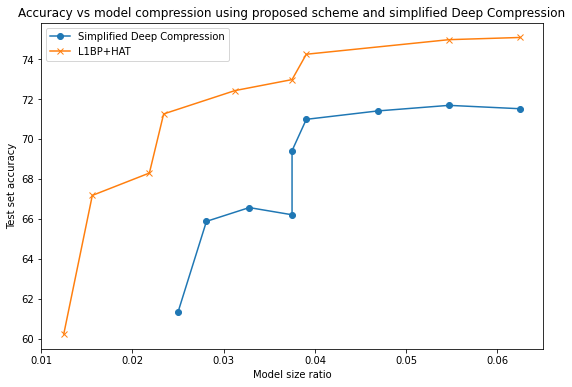

In [ ]:
import matplotlib.pyplot as plt
orig_compr = [0.25*0.25,0.25*7/32,0.25*6/32,0.25*5/32,0.2*6/32,0.15*0.25,0.15*7/32,0.15*6/32,0.1*8/32]
orig_acc   = [71.51,71.68,71.4,70.98,69.41,66.2,66.56,65.87,61.31]

mod_compr = [0.25*0.25,0.25*7/32,0.25*5/32,0.2*6/32,0.2*5/32,0.15*5/32,0.1*7/32,0.1*5/32,0.1*4/32]
mod_acc   = [75.08,74.97,74.24,72.97,72.42,71.25,68.29,67.17,60.23]

fig = plt.figure(1,figsize=(9,6))
plt.plot(orig_compr, orig_acc, label='Simplified Deep Compression',marker='o')
plt.plot(mod_compr, mod_acc, label='L1BP+HAT',marker='x')

# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.7296,0.7184,0.6972,0.6369,0.4878,0.4205], label='Original model',marker='o')
# plt.plot([0.7,0.75,0.8,0.85,0.9,0.95,0.96],[0.735,0.734,0.7269,0.6999,0.64,0.5001,0.4502], label='Regularized model',marker='x')
plt.xlabel('Model size ratio')
plt.ylabel('Test set accuracy')
plt.legend()
plt.title('Accuracy vs model compression using proposed scheme and simplified Deep Compression')
fig.savefig('overall_comparison.pdf')

#### Test the model
Testing trained model on ImageNet images.

**NOTE:** Change model to have 1000 output classes for this section to work.


(?, 56, 56, 96)
(?, 27, 27, 256)
(?, 13, 13, 384)
(?, 13, 13, 384)
(?, 13, 13, 256)
(?, 9216)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


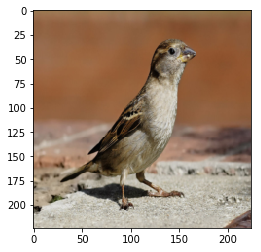

81


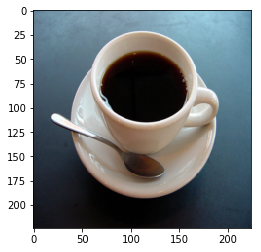

967


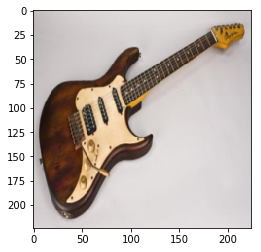

546


In [ ]:
# test the AlexNet model on the given images
import PIL
from imageio import imread
from scipy.misc import imre```size, imshow
import os

#get list of all images
current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'drive/My Drive/Colab Notebooks/test_images')
img_files = [os.path.join(image_path, f) for f in os.listdir(image_path) if f.endswith('.jpg')]


#load all images
imgs = []
for f in img_files:
    imgs.append(imread(f))

reset_graph()

# init_l = tf.local_variables_initializer()
with tf.Session() as sess:
    X = tf.placeholder(shape=[None, 224, 224, 3], dtype=tf.float32, name='X')
    alex = AlexNet(X)
    init = tf.global_variables_initializer()
    sess.run(init)
#     sess.run(init_l)
    load_initial_weights(sess) 
    
    
    # loop over all images
    for i, image in enumerate(imgs):
        # convert image to float32 and resize to (227x227)
        img = imresize(image, (224, 224, 3)).astype(np.float32)
        
        import matplotlib.pyplot as plt
        plt.imshow(np.uint8(img))
        plt.show()
        # subtract the ImageNet mean
        # Mean subtraction per channel was used to center the data around zero mean for each channel (R, G, B).
        # This typically helps the network to learn faster since gradients act uniformly for each channel.
        imagenet_mean = np.array([104., 117., 124.], dtype=np.float32)
        img -= imagenet_mean
        
        # reshape as needed to feed into model
        img = img.reshape((1, 224, 224, 3))
        
        output = sess.run(alex, feed_dict={X: img})
        
        print(np.argmax(output))

In [ ]:
import numpy as np
np.version__